In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn import decomposition, manifold
from sklearn import metrics
from crm_rfm_modeling.rfm import RFM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn import metrics
from kmodes import kprototypes
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import squarify
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)
%matplotlib inline

## **I - Classical RFM study (on a six month base value)**

### **Importing our data (for all time period) transforming date to datetime**

In [2]:
df_data_global_olist = pd.read_csv('data_global_olist.csv', index_col=0)
df_data_global_olist['order_purchase_timestamp'] = pd.to_datetime(
    df_data_global_olist['order_purchase_timestamp'])

#### Function to regroup all data per customer unique by time period (from or EDA file)

In [3]:
def customer_infos_time(df, time_start, time_stop, name='none'):
    ''' Function to create a dataset of all the data that we wanted for an unique client id for a time period
    the data set raw with all the variable we wanted must be implemented, base is data_global_olist_final
    (important columns with order_purchase_timestamp should be present)
    time start and time end must be input
    the name of the dataframe is optional
    it returns:
    - a new dataframe with a row for each client: R, F, M, main_prod_cat, nb_product by order, top seller, mean_seller_dist_km, 
    mean payment by order, mean_sequential, mean_order_review, mean_shipping_delay_days, main_payment_type  columns
    - a new dataframe data_global_olist filtered for the time-period'''
    # filtering the time period
    df_filtered = df.loc[df['order_purchase_timestamp'].between(
        time_start, time_stop, inclusive='both')].copy()
    # creating R column and payment_total
    recent_date = df_filtered['order_purchase_timestamp'].max()
    df_filtered['R'] = (
        recent_date - df_filtered['order_purchase_timestamp']).dt.days
    # groupby for each client
    df_data_RFM_filtered = df_filtered.groupby('customer_unique_id').agg(R=('R', min), F=('order_id', pd.Series.nunique),
                                                                         M=('payment_value_total', lambda x: x.unique().sum()), main_prod_cat=('category_name', lambda x: x.value_counts().index[0] if len(x.value_counts()) != 0 else np.nan),
                                                                         nb_prod=('order_item_id', pd.Series.count), nb_prod_by_order=('order_id', lambda x: len(x)/x.nunique()),
                                                                         top_seller=('seller_id', lambda x: x.value_counts(
                                                                         ).index[0] if len(x.value_counts()) != 0 else np.nan),
                                                                         mean_seller_dist_km=(
                                                                             'distance_km_customer_seller', lambda x: np.mean(x)),
                                                                         mean_shipping_delay_days=('shipping_delay_days', lambda x: np.mean(x)))
    # add column mean payment by order
    df_data_RFM_filtered['mean_payment_by_order'] = df_data_RFM_filtered['M'] / \
        df_data_RFM_filtered['F']
    # filtereing df by order to add mean sequential and mean order review by clients
    df_order = df.groupby('order_id').agg(customer_unique_id=('customer_unique_id', pd.Series.unique), sequential=(
        'sequential', pd.Series.unique), review=('order_last_review_score', pd.Series.unique), payment_type=('main_payment_type', pd.Series.unique))
    df_order_customer = df_order.groupby('customer_unique_id').agg(mean_sequential=(
        'sequential', pd.Series.mean), mean_review_score=('review', pd.Series.mean),
        main_payment_type=('payment_type', lambda x: x.value_counts().index[0] if len(x.value_counts()) != 0 else np.nan))
    # merge last data
    df_data_RFM_filtered = pd.merge(
        df_data_RFM_filtered, df_order_customer, left_index=True, right_on='customer_unique_id', how='left')
    df_data_RFM_filtered.name = name
    return df_data_RFM_filtered, df_filtered

In [4]:
print(
    f'the date of the older order is: {df_data_global_olist.order_purchase_timestamp.min()}')
print(
    f'the date of the most recent order is: {df_data_global_olist.order_purchase_timestamp.max()}')

the date of the older order is: 2016-10-03 09:44:50
the date of the most recent order is: 2018-08-29 15:00:37


### **Creating our data by customer for 2017 first semester**

In [5]:
df_data_RFM_period, df_data_global_olist_period = customer_infos_time(
    df_data_global_olist, '2017-01-01', '2017-06-30', name='Data_customer_period')
df_data_RFM_period

R  F       M             main_prod_cat  \
customer_unique_id                                                           
0000f46a3911fa3c0805444483337064  111  1   86.22                stationery   
0005e1862207bf6ccc02e4228effd9a0  116  1  150.12  fashion_bags_accessories   
00115fc7123b5310cf6d3a3aa932699e  159  1   76.11            sports_leisure   
0011805441c0d1b68b48002f1d005526   66  1  297.14     computers_accessories   
0011857aff0e5871ce5eb429f21cdaf5    1  1  192.83       luggage_accessories   
...                               ... ..     ...                       ...   
ffebb6424578e7bb153322da9d65634f  164  1  665.70                cool_stuff   
ffedff0547d809c90c05c2691c51f9b7   91  1   32.42                housewares   
ffef0ffa736c7b3d9af741611089729b   31  1  139.07            sports_leisure   
ffff371b4d645b6ecea244b27531430a  142  1  112.46                      auto   
ffffd2657e2aad2907e67c3e9daecbeb   58  1   71.56                 perfumery   

                                  nb_prod  nb_prod_by_order  \
customer_unique_id                                            
0000f46a3911fa3c0805444483337064      1.0               1.0   
0005e1862207bf6ccc02e4228effd9a0      1.0               1.0   
00115fc7123b5310cf6d3a3aa932699e      1.0               1.0   
0011805441c0d1b68b48002f1d005526      1.0               1.0   
0011857aff0e5871ce5eb429f21cdaf5      1.0               1.0   
...                                   ...               ...   
ffebb6424578e7bb153322da9d65634f      1.0               1.0   
ffedff0547d809c90c05c2691c51f9b7      1.0               1.0   
ffef0ffa736c7b3d9af741611089729b      1.0               1.0   
ffff371b4d645b6ecea244b27531430a      1.0               1.0   
ffffd2657e2aad2907e67c3e9daecbeb      1.0               1.0   

                                                        top_seller  \
customer_unique_id                                                   
0000f46a3911fa3c0805444483337064  3d871de0142ce09b7081e2b9d1733cb1   
0005e1862207bf6ccc02e4228effd9a0  0cbcee27c791afa0cdcb08587a2013a8   
00115fc7123b5310cf6d3a3aa932699e  54a1852d1b8f10312c55e906355666ee   
0011805441c0d1b68b48002f1d005526  96493fab2fbb13a14d0c0e8772eef5c3   
0011857aff0e5871ce5eb429f21cdaf5  9d5a9018aee56acb367ba9c3f05d1d6a   
...                                                            ...   
ffebb6424578e7bb153322da9d65634f  dc317f341ab0e22f39acbd9dbf9b4a1f   
ffedff0547d809c90c05c2691c51f9b7  dd2bdf855a9172734fbc3744021ae9b9   
ffef0ffa736c7b3d9af741611089729b  c3cfdc648177fdbbbb35635a37472c53   
ffff371b4d645b6ecea244b27531430a  54aa8463e87776b5612f4bdc4bd5d4de   
ffffd2657e2aad2907e67c3e9daecbeb  cc419e0650a3c5ba77189a1882b7556a   

                                  mean_seller_dist_km  \
customer_unique_id                                      
0000f46a3911fa3c0805444483337064           517.883143   
0005e1862207bf6ccc02e4228effd9a0           245.860181   
00115fc7123b5310cf6d3a3aa932699e           774.662274   
0011805441c0d1b68b48002f1d005526          2211.443664   
0011857aff0e5871ce5eb429f21cdaf5           819.508679   
...                                               ...   
ffebb6424578e7bb153322da9d65634f           857.245703   
ffedff0547d809c90c05c2691c51f9b7           425.655874   
ffef0ffa736c7b3d9af741611089729b          1185.417662   
ffff371b4d645b6ecea244b27531430a          1527.160181   
ffffd2657e2aad2907e67c3e9daecbeb           356.318489   

                                  mean_shipping_delay_days  \
customer_unique_id                                           
0000f46a3911fa3c0805444483337064                      25.0   
0005e1862207bf6ccc02e4228effd9a0                       4.0   
00115fc7123b5310cf6d3a3aa932699e                      10.0   
0011805441c0d1b68b48002f1d005526                      18.0   
0011857aff0e5871ce5eb429f21cdaf5                       8.0   
...                                                    ...   
ffebb6424578e7bb153322da9d65634f                    

--> there is 13266 client to include in the RFM study. Let's vizualise the distribution of our variables

### **Visualization of our RFM data**

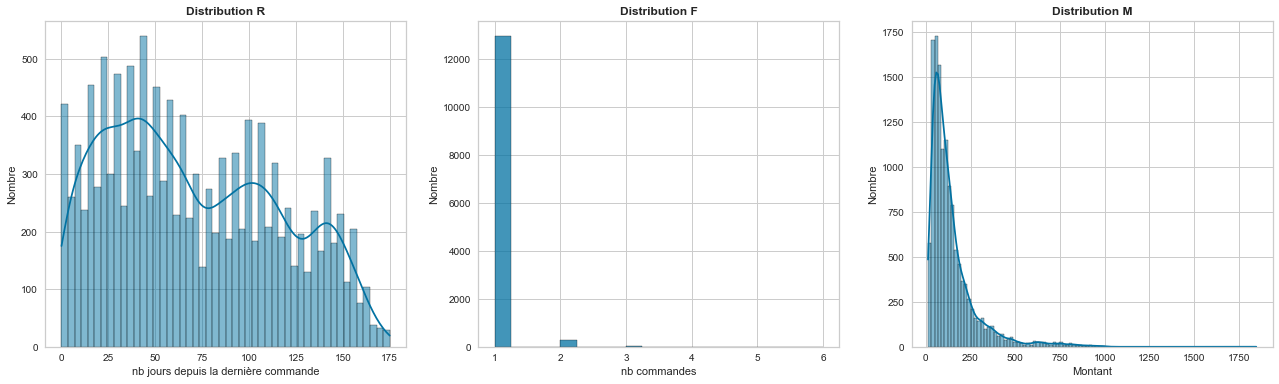

In [6]:
figure_1 = plt.figure(figsize=(22, 6))
figure_1.add_subplot(1, 3, 1)
plt.title('Distribution R', fontweight='bold')
sns.histplot(data=df_data_RFM_period['R'], bins=50, kde=True)
plt.xlabel('nb jours depuis la dernière commande')
plt.ylabel('Nombre')
figure_1.add_subplot(1, 3, 2)
plt.title('Distribution F', fontweight='bold')
sns.histplot(data=df_data_RFM_period['F'], bins=20)
plt.xlabel('nb commandes')
plt.ylabel('Nombre')
figure_1.add_subplot(1, 3, 3)
plt.title('Distribution M', fontweight='bold')
sns.histplot(data=df_data_RFM_period['M'], bins=100, kde=True)
plt.xlabel('Montant')
plt.ylabel('Nombre')
#plt.savefig('RFM_données_à_utiliser.jpg', dpi=300, bbox_inches='tight')
plt.show()

--> A lot of customers order only 1 time (already seen) and lots of payment are under 500 <br/>
--> R and F value are not centered <br/>
--> let's try to range our customer in several categories by variables and create an RFM score <br/>

### **RFM scores construction and visualization**

In [7]:
df_data_RFM_period.describe([0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.99])

R             F             M       nb_prod  \
count  13266.000000  13266.000000  13266.000000  13266.000000   
mean      70.625961      1.025102    145.017123      1.156189   
std       45.493133      0.173790    138.203110      0.528593   
min        0.000000      1.000000     12.280000      1.000000   
10%       14.000000      1.000000     38.770000      1.000000   
20%       26.000000      1.000000     52.740000      1.000000   
40%       50.000000      1.000000     82.730000      1.000000   
50%       64.000000      1.000000    103.550000      1.000000   
60%       82.000000      1.000000    125.520000      1.000000   
70%       99.000000      1.000000    153.100000      1.000000   
80%      115.000000      1.000000    201.730000      1.000000   
90%      140.000000      1.000000    301.555000      2.000000   
99%      163.000000      2.000000    755.550500      4.000000   
max      175.000000      6.000000   1846.860000     15.000000   

       nb_prod_by_order  mean_seller_dist_km  mean_shipping_delay_days  \
count      13266.000000         13266.000000              13266.000000   
mean           1.126589           632.608950                 12.065800   
std            0.469269           608.747498                 10.652262   
min            1.000000             0.000000                  0.000000   
10%            1.000000            47.534100                  5.000000   
20%            1.000000           157.490785                  6.000000   
40%            1.000000           361.174468                  9.000000   
50%            1.000000           457.494665                 10.000000   
60%            1.000000           551.966775                 12.000000   
70%            1.000000           724.342681                 13.000000   
80%            1.000000           903.452104                 16.000000   
90%            1.000000          1494.707188                 20.000000   
99%            3.000000          2624.504949                 43.000000   
max           15.000000          3346.890807                209.000000   

       mean_payment_by_order  mean_sequential  mean_review_score  
count           13266.000000     13266.000000       13266.000000  
mean              142.061918         1.061090           4.184852  
std               134.261057         0.509595           1.227495  
min                 8.976667         1.000000           1.000000  
10%                38.420000         1.000000           2.000000  
20%                52.100000         1.000000           3.000000  
40%                81.780000         1.000000           4.000000  
50%               102.030000         1.000000           5.000000  
60%               123.250000         1.000000           5.000000  
70%               150.385000         1.000000           5.000000  
80%               196.805000         1.000000           5.000000  
90%               293.750000         1.000000           5.000000  
99%               743.945000         2.000000           5.000000  
max               995.180000        26.000000           5.000000

--> Let's try a first segmentation with score concatenate for each variables

In [8]:
df_data_RFM_period['R_score'] = pd.qcut(
    df_data_RFM_period['R'], q=3, labels=[3, 2, 1])
df_data_RFM_period['F_score'] = pd.cut(df_data_RFM_period['F'], bins=[
    0, 1, 4, 6], labels=[1, 2, 3])
df_data_RFM_period['M_score'] = pd.qcut(
    df_data_RFM_period['M'], q=[0, 0.2, 0.8, 1], labels=[1, 2, 3])

--> RFM final score creation with other scores

In [9]:
df_data_RFM_period['RFM_score'] = df_data_RFM_period['R_score'].astype(
    str)+df_data_RFM_period['F_score'].astype(str)+df_data_RFM_period['M_score'].astype(str)

In [10]:
df_data_RFM_period['RFM_score'].value_counts().sort_index()

111     923
112    2479
113     848
121       9
122      32
123      37
132       1
211     880
212    2617
213     879
221       7
222      42
223      40
311     829
312    2721
313     786
321       6
322      67
323      63
Name: RFM_score, dtype: int64

In [11]:
len(df_data_RFM_period['RFM_score'].value_counts().index)

19

--> There is 19 score possible <br/>
--> let's plot the distribution of our segmentation

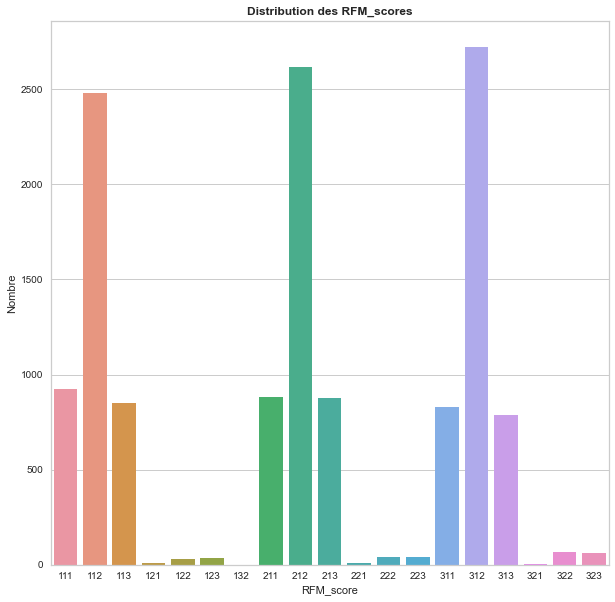

In [12]:
figure_2 = plt.figure(figsize=(10, 10))
plt.title('Distribution des RFM_scores', fontweight='bold')
sns.barplot(x=df_data_RFM_period['RFM_score'].value_counts().sort_index(
).index, y=df_data_RFM_period['RFM_score'].value_counts().sort_index())
plt.ylabel('Nombre')
plt.xlabel('RFM_score')
plt.show()

--> 6 groups seems to appear clearly.<br/>
--> let's try to define a segmentation in function of the RFM scoring

### **RFM segment construction and visualization**

#### function to define a group for clients regarding their RFM score

In [13]:
def segment(x_score):
    ''' Function to convert our RFM segment score into 6 client segments
    x_score must be a concatenation of the tree scores as str'''
    if x_score in ['333', '323']:
        return('CHAMPION')
    if x_score in ['221', '222', '223', '321', '322', '221']:
        return('FIDELE')
    if x_score in ['311', '312', '313']:
        return('NOUVEAU')
    if x_score in ['121', '122', '123', '132']:
        return('A RISQUE')
    if x_score in ['111', '112', '113']:
        return('PERDU')
    if x_score in ['211', '212', '213']:
        return('A RECONQUERIR')

In [14]:
df_data_RFM_period['RFM_segment'] = df_data_RFM_period['RFM_score'].apply(
    segment)
df_data_RFM_period

R  F       M             main_prod_cat  \
customer_unique_id                                                           
0000f46a3911fa3c0805444483337064  111  1   86.22                stationery   
0005e1862207bf6ccc02e4228effd9a0  116  1  150.12  fashion_bags_accessories   
00115fc7123b5310cf6d3a3aa932699e  159  1   76.11            sports_leisure   
0011805441c0d1b68b48002f1d005526   66  1  297.14     computers_accessories   
0011857aff0e5871ce5eb429f21cdaf5    1  1  192.83       luggage_accessories   
...                               ... ..     ...                       ...   
ffebb6424578e7bb153322da9d65634f  164  1  665.70                cool_stuff   
ffedff0547d809c90c05c2691c51f9b7   91  1   32.42                housewares   
ffef0ffa736c7b3d9af741611089729b   31  1  139.07            sports_leisure   
ffff371b4d645b6ecea244b27531430a  142  1  112.46                      auto   
ffffd2657e2aad2907e67c3e9daecbeb   58  1   71.56                 perfumery   

                                  nb_prod  nb_prod_by_order  \
customer_unique_id                                            
0000f46a3911fa3c0805444483337064      1.0               1.0   
0005e1862207bf6ccc02e4228effd9a0      1.0               1.0   
00115fc7123b5310cf6d3a3aa932699e      1.0               1.0   
0011805441c0d1b68b48002f1d005526      1.0               1.0   
0011857aff0e5871ce5eb429f21cdaf5      1.0               1.0   
...                                   ...               ...   
ffebb6424578e7bb153322da9d65634f      1.0               1.0   
ffedff0547d809c90c05c2691c51f9b7      1.0               1.0   
ffef0ffa736c7b3d9af741611089729b      1.0               1.0   
ffff371b4d645b6ecea244b27531430a      1.0               1.0   
ffffd2657e2aad2907e67c3e9daecbeb      1.0               1.0   

                                                        top_seller  \
customer_unique_id                                                   
0000f46a3911fa3c0805444483337064  3d871de0142ce09b7081e2b9d1733cb1   
0005e1862207bf6ccc02e4228effd9a0  0cbcee27c791afa0cdcb08587a2013a8   
00115fc7123b5310cf6d3a3aa932699e  54a1852d1b8f10312c55e906355666ee   
0011805441c0d1b68b48002f1d005526  96493fab2fbb13a14d0c0e8772eef5c3   
0011857aff0e5871ce5eb429f21cdaf5  9d5a9018aee56acb367ba9c3f05d1d6a   
...                                                            ...   
ffebb6424578e7bb153322da9d65634f  dc317f341ab0e22f39acbd9dbf9b4a1f   
ffedff0547d809c90c05c2691c51f9b7  dd2bdf855a9172734fbc3744021ae9b9   
ffef0ffa736c7b3d9af741611089729b  c3cfdc648177fdbbbb35635a37472c53   
ffff371b4d645b6ecea244b27531430a  54aa8463e87776b5612f4bdc4bd5d4de   
ffffd2657e2aad2907e67c3e9daecbeb  cc419e0650a3c5ba77189a1882b7556a   

                                  mean_seller_dist_km  \
customer_unique_id                                      
0000f46a3911fa3c0805444483337064           517.883143   
0005e1862207bf6ccc02e4228effd9a0           245.860181   
00115fc7123b5310cf6d3a3aa932699e           774.662274   
0011805441c0d1b68b48002f1d005526          2211.443664   
0011857aff0e5871ce5eb429f21cdaf5           819.508679   
...                                               ...   
ffebb6424578e7bb153322da9d65634f           857.245703   
ffedff0547d809c90c05c2691c51f9b7           425.655874   
ffef0ffa736c7b3d9af741611089729b          1185.417662   
ffff371b4d645b6ecea244b27531430a          1527.160181   
ffffd2657e2aad2907e67c3e9daecbeb           356.318489   

                                  mean_shipping_delay_days  \
customer_unique_id                                           
0000f46a3911fa3c0805444483337064                      25.0   
0005e1862207bf6ccc02e4228effd9a0                       4.0   
00115fc7123b5310cf6d3a3aa932699e                      10.0   
0011805441c0d1b68b48002f1d005526                      18.0   
0011857aff0e5871ce5eb429f21cdaf5                       8.0   
...                                                    ...   
ffebb6424578e7bb153322da9d65634f                    

--> Let's try to summarize the results by segment and visualize it

#### Function to groupby informations by segment (or cluster)

In [15]:
def cluster_result(df_customer, column_cluster):
    ''' Function to agglomerate data for each cluster find
    df_customer is the only input, must contain data for each customer'''
    df_result = df_customer.groupby(column_cluster).agg(
        Number=(column_cluster, pd.Series.value_counts), Total_ammount=('M', sum), mean_R=('R', pd.Series.mean),
        mean_F=('F', pd.Series.mean), mean_M=('M', pd.Series.mean), mean_payment_by_order=('mean_payment_by_order', pd.Series.mean),
        mean_seller_dist_km=('mean_seller_dist_km', pd.Series.mean), mean_shipping_delay_days=('mean_shipping_delay_days', pd.Series.mean),
        mean_review_score=('mean_review_score', pd.Series.mean),
        mean_nb_prod=('nb_prod', pd.Series.mean), mean_prod_by_order=('nb_prod_by_order', pd.Series.mean),
        main_cat_prod=('main_prod_cat', lambda x: x.value_counts().index[0]),
        main_payment_type=('main_payment_type', lambda x: x.value_counts().index[0]))
    df_result = df_result.sort_values('Number', ascending=False)
    df_result['ratio_expenditure'] = df_result['Total_ammount'] / \
        df_result['Number']
    return df_result

In [16]:
df_result_rfm = cluster_result(df_data_RFM_period, 'RFM_segment')
df_result_rfm

Number  Total_ammount      mean_R    mean_F      mean_M  \
RFM_segment                                                              
A RECONQUERIR    4376      628991.25   65.955667  1.000000  143.736574   
NOUVEAU          4336      603108.03   21.886070  1.000000  139.093180   
PERDU            4250      615576.24  125.720471  1.000000  144.841468   
FIDELE            162       30149.71   45.888889  2.049383  186.109321   
A RISQUE           79       19123.69  130.797468  2.177215  242.072025   
CHAMPION           63       26848.23   21.031746  2.111111  426.162381   

               mean_payment_by_order  mean_seller_dist_km  \
RFM_segment                                                 
A RECONQUERIR             143.736574           667.861855   
NOUVEAU                   139.093180           590.574543   
PERDU                     144.841468           641.875198   
FIDELE                     91.156307           609.335297   
A RISQUE                  116.976835           557.230206   
CHAMPION                  204.910926           606.230832   

               mean_shipping_delay_days  mean_review_score  mean_nb_prod  \
RFM_segment                                                                
A RECONQUERIR                 12.962294           4.157488      1.116773   
NOUVEAU                       10.839253           4.221940      1.113238   
PERDU                         12.424235           4.176451      1.145882   
FIDELE                        11.783436           4.157407      2.345679   
A RISQUE                      10.893978           4.016878      2.683544   
CHAMPION                      12.228042           4.380952      2.571429   

               mean_prod_by_order    main_cat_prod main_payment_type  \
RFM_segment                                                            
A RECONQUERIR            1.116773   bed_bath_table       credit_card   
NOUVEAU                  1.113238   bed_bath_table       credit_card   
PERDU                    1.145882  furniture_decor       credit_card   
FIDELE                   1.146091   bed_bath_table       credit_card   
A RISQUE                 1.244726   bed_bath_table       credit_card   
CHAMPION                 1.227513   bed_bath_table       credit_card   

               ratio_expenditure  
RFM_segment                       
A RECONQUERIR         143.736574  
NOUVEAU               139.093180  
PERDU                 144.841468  
FIDELE                186.109321  
A RISQUE              242.072025  
CHAMPION              426.162381

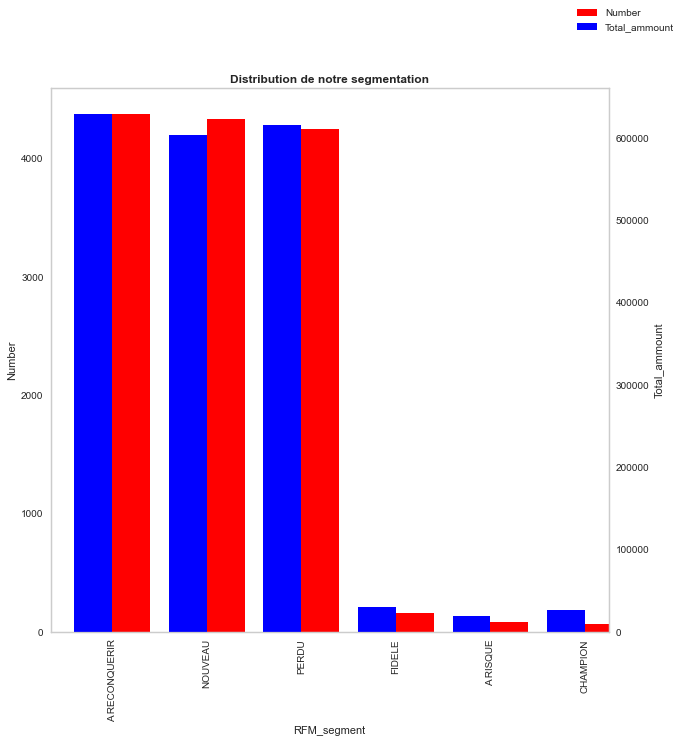

In [17]:
figure_3 = plt.figure(figsize=(10, 10))
plt.title('Distribution de notre segmentation', fontweight='bold')
width = 0.4
df_result_rfm['Number'].plot(kind='bar', color='red', width=width, position=0)
plt.ylabel('Number')
plt.grid(b=False)
ax2 = plt.twinx()
df_result_rfm['Total_ammount'].plot(
    kind='bar', color='blue', ax=ax2, width=width, position=1)
plt.ylabel('Total_ammount')
plt.grid(b=False)
figure_3.legend()
plt.show()

--> Let's try radar plot to identify our RFM segment

#### Function to create radar plot by segment (or cluster)

In [18]:
def radar_plot_groups(df_data, list_column, markers, name, color_cluster, plot_size=(10, 10), savefig=False):
    '''Function to plot a radar plot for each group we want to analyse. all input except plot_size should be entered. The index of the df must be the name of groups
    df_data --> df to use
    list_column --> should be the list of characteristics to show as axes of the radar plot. Careful a inmax scaler is applyed to each mean values
    markers --> the scale to use in the radar plot.Should be a list
    name --> The name of the graphic
    color_cluster --> color palette to use for the cluster, need a color by group
    plot_size --> size of the figure, must be a tuple with 2 dimension, (10,10) by default
    savefig --> posibility to save the figures, false by default'''
    data = df_data[list_column].copy()
    # min max scaler to display value by group between 0 and 1
    quantile_tf = QuantileTransformer(n_quantiles=4, random_state=0)
    quantile_tf.fit(data)
    quantile_transform = quantile_tf.transform(data)
    data = pd.DataFrame(
        data=quantile_transform, columns=data.columns, index=data.index)
    # define general information to put into each graphic
    labels = data.columns
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    angles2 = np.concatenate((angles, [angles[0]]))
    figure = plt.figure(figsize=plot_size)
    plt.title(f'Radar plot: {name}', fontweight='bold', pad=50, size=18)
    plt.axis('off')
    count = 1
    # plot for each Group the radar plot
    for group in data.index:
        # defining the values to use for each group
        values = np.array(data.loc[group, :])
        stats = np.concatenate((values, [values[0]]))
        # ploting radar plot for one group
        if len(data.index) % 3 != 0:
            ax = figure.add_subplot(
                (len(data.index)+1)//3, 3, count, polar=True)
        else:
            ax = figure.add_subplot(len(data.index)//3, 3, count, polar=True)
        ax.plot(angles2, stats, 'o-', linewidth=2,
                color=color_cluster[count-1])
        ax.fill(angles2, stats, alpha=0.4, color=color_cluster[count-1])
        ax.set_thetagrids(angles * 180/np.pi, labels)
        plt.yticks(markers, size=8)
        ax.set_title(f'Cluster: {group}', fontweight='bold', pad=15, size=12)
        ax.grid(True)
        count += 1

    if savefig == True:
        plt.savefig(f'Radar_plot: {name}.jpg', dpi=300, bbox_inches='tight')
    else:
        print('figure not saved')
    plt.show()
    # pie chart repartition of cluster
    figure_pie = plt.figure(figsize=(10, 10), facecolor='w')
    x = df_data['Number']
    plt.title(f'Répartition des {name}',
              fontweight='bold', fontsize=14)
    expl = [0 if i/x.sum() > 0.02 else 0.5 for i in x]
    plt.pie(x, labels=[i for i in x.index], autopct="%.1f%%", pctdistance=0.8,
            explode=expl, textprops={'fontsize': 10, 'fontweight': 'bold'}, colors=color_cluster)
    if savefig == True:
        plt.savefig(f'Répartition {name}.jpg', dpi=300, bbox_inches='tight')
    else:
        print('figure not saved')
    return plt.show()

In [19]:
# defining color palette for each segment
color_segment = plt.cm.Set2(range(0, len(df_result_rfm)))

figure not saved


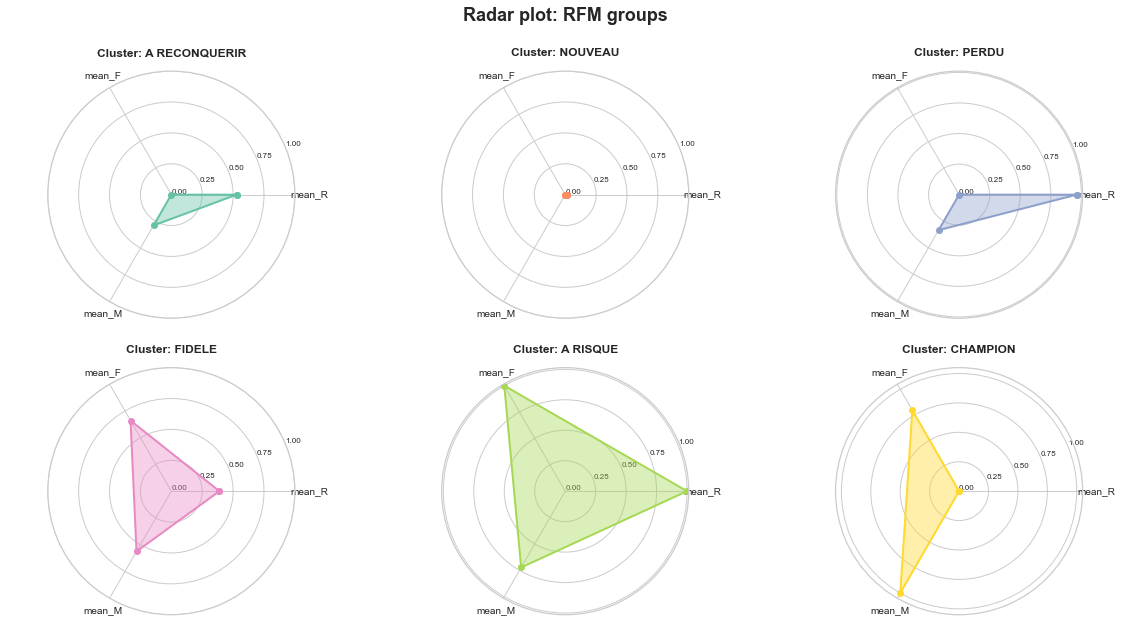

figure not saved


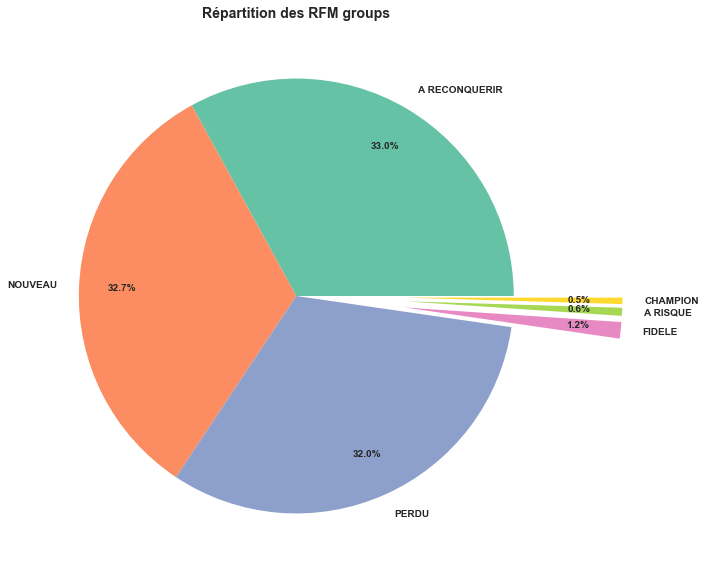

In [20]:
radar_plot_groups(df_result_rfm, ['mean_R', 'mean_F', 'mean_M'], markers=[
                  0, 0.25, 0.50, 0.75, 1], name='RFM groups', color_cluster=color_segment, plot_size=(20, 10))

--> let's quantify the population of our segment with treemap

#### Function to create treemap of our segment (or cluster)

In [21]:
def treemap(df_data, column, name, color_cluster, plot_size=(10, 10), savefig=False):
    '''Function to create a treemap of aggregate data concerning groups of data. It needs squarify library!!
    df_data --> dataframe of the data to input already grouped
    column --> name of the column where to find the aggregate data for the treemap (only one!!)
    name --> name of the group to represent
    colorcluster --> color palette to use for the cluster, it needs a color by group
    plot_size --> size of the figure, must be a tuple with 2 dimension, (10,10) by default
    savefig --> possibility to save the figure, False by default'''
    pop_group = df_data[column]
    group_text = list()

    for group in pop_group.index:
        group_text.append(
            f'{group}\n{((pop_group.loc[group])/(pop_group.sum()))*100:.2f} %\n ({pop_group.loc[group]:.0f})')

    plt.figure(figsize=plot_size)
    plt.axis('off')
    plt.title(f'Répartition: {name}',
              size=15, fontweight='bold')
    squarify.plot(sizes=pop_group, label=group_text,
                  color=color_cluster, alpha=0.9)
    if savefig == True:
        plt.savefig(f'Treemap{name}.jpg', dpi=300, bbox_inches='tight')
    else:
        print('figure not saved')
    return plt.show()

figure not saved


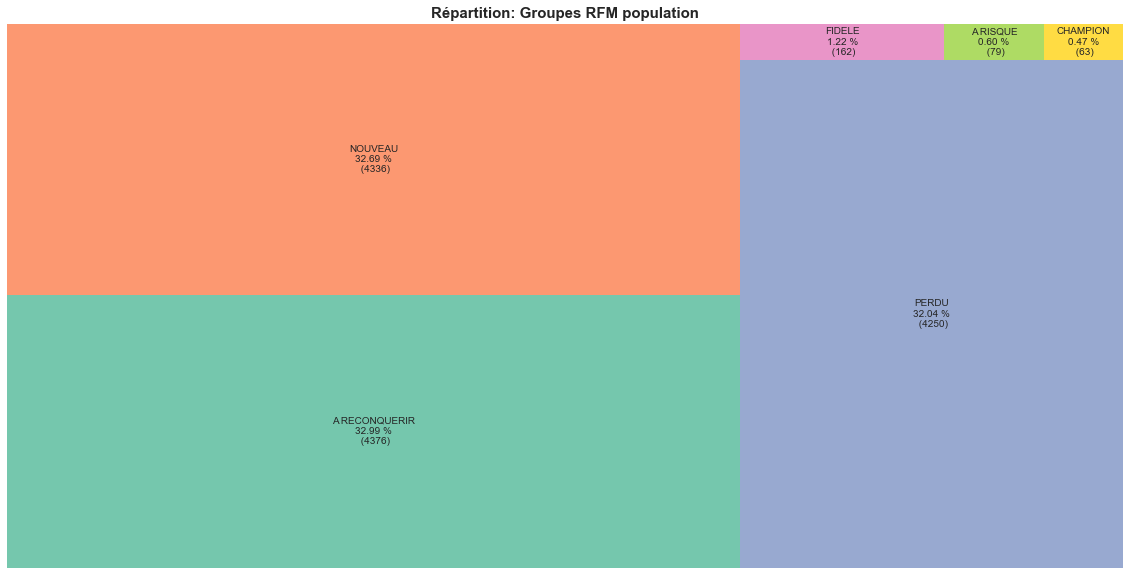

In [22]:
treemap(df_result_rfm, 'Number', 'Groupes RFM population',
        color_cluster=color_segment, plot_size=(20, 10))

--> Let's focus on specific customer informations for each segment

#### Function to focus on specifics customers informations by segment (or cluster)

In [23]:
# list specific informations by customers
def boxplot_specific_customer_infos_by_group(df_customer, df_cluster_result, column_cluster, colors, savefig=False):
    '''Function to boxplot for each cluster specifics information regarding customers
    df_customer --> data grouped for each customer (need to containt their group membership)
    df_cluster_result --> data aggregate with cluster result function
    colors --> the color palette for each group to use (in order of df_cluster_result index)
    savefig --> possibility to save the figure, False by default'''
    list_cust_info = ['nb_prod', 'nb_prod_by_order',
                      'mean_seller_dist_km', 'mean_payment_by_order', 'mean_sequential', 'mean_review_score']
    dico_name = {'nb_prod': 'Nombre de produits', 'nb_prod_by_order': 'Nombre de produits par commande',
                 'mean_seller_dist_km': 'Distance moyenne (km) avec le vendeur', 'mean_payment_by_order': 'Valeur du panier moyen',
                 'mean_sequential': 'Payment en plusieurs fois', 'mean_review_score': 'Note moyenne'}
    figure_specific_info = plt.figure(figsize=(30, 20))
    plt.title('Distributions d informations spécifiques aux clients par groupe',
              fontweight='bold', fontsize=18)
    plt.axis('off')
    count = 1
    for name in df_customer[list_cust_info].columns:
        figure_specific_info.add_subplot(2, 3, count)
        ax = sns.boxplot(x=column_cluster, y=name, order=df_cluster_result.index,
                         data=df_customer, palette=colors, showfliers=False)
        plt.xticks(rotation=90, fontweight='bold', fontsize=10)
        # Using french traduction for ylabel
        plt.ylabel(dico_name[name], fontweight='bold', fontsize=16)
        # do not display the x axis name
        x_axis = ax.axes.get_xaxis()
        x_label = x_axis.get_label()
        x_label.set_visible(False)
        count += 1
    if savefig == True:
        plt.savefig(f'Customer_info_boxplots.jpg',
                    dpi=300, bbox_inches='tight')
    else:
        print('figure not saved')
    plt.show()

figure not saved


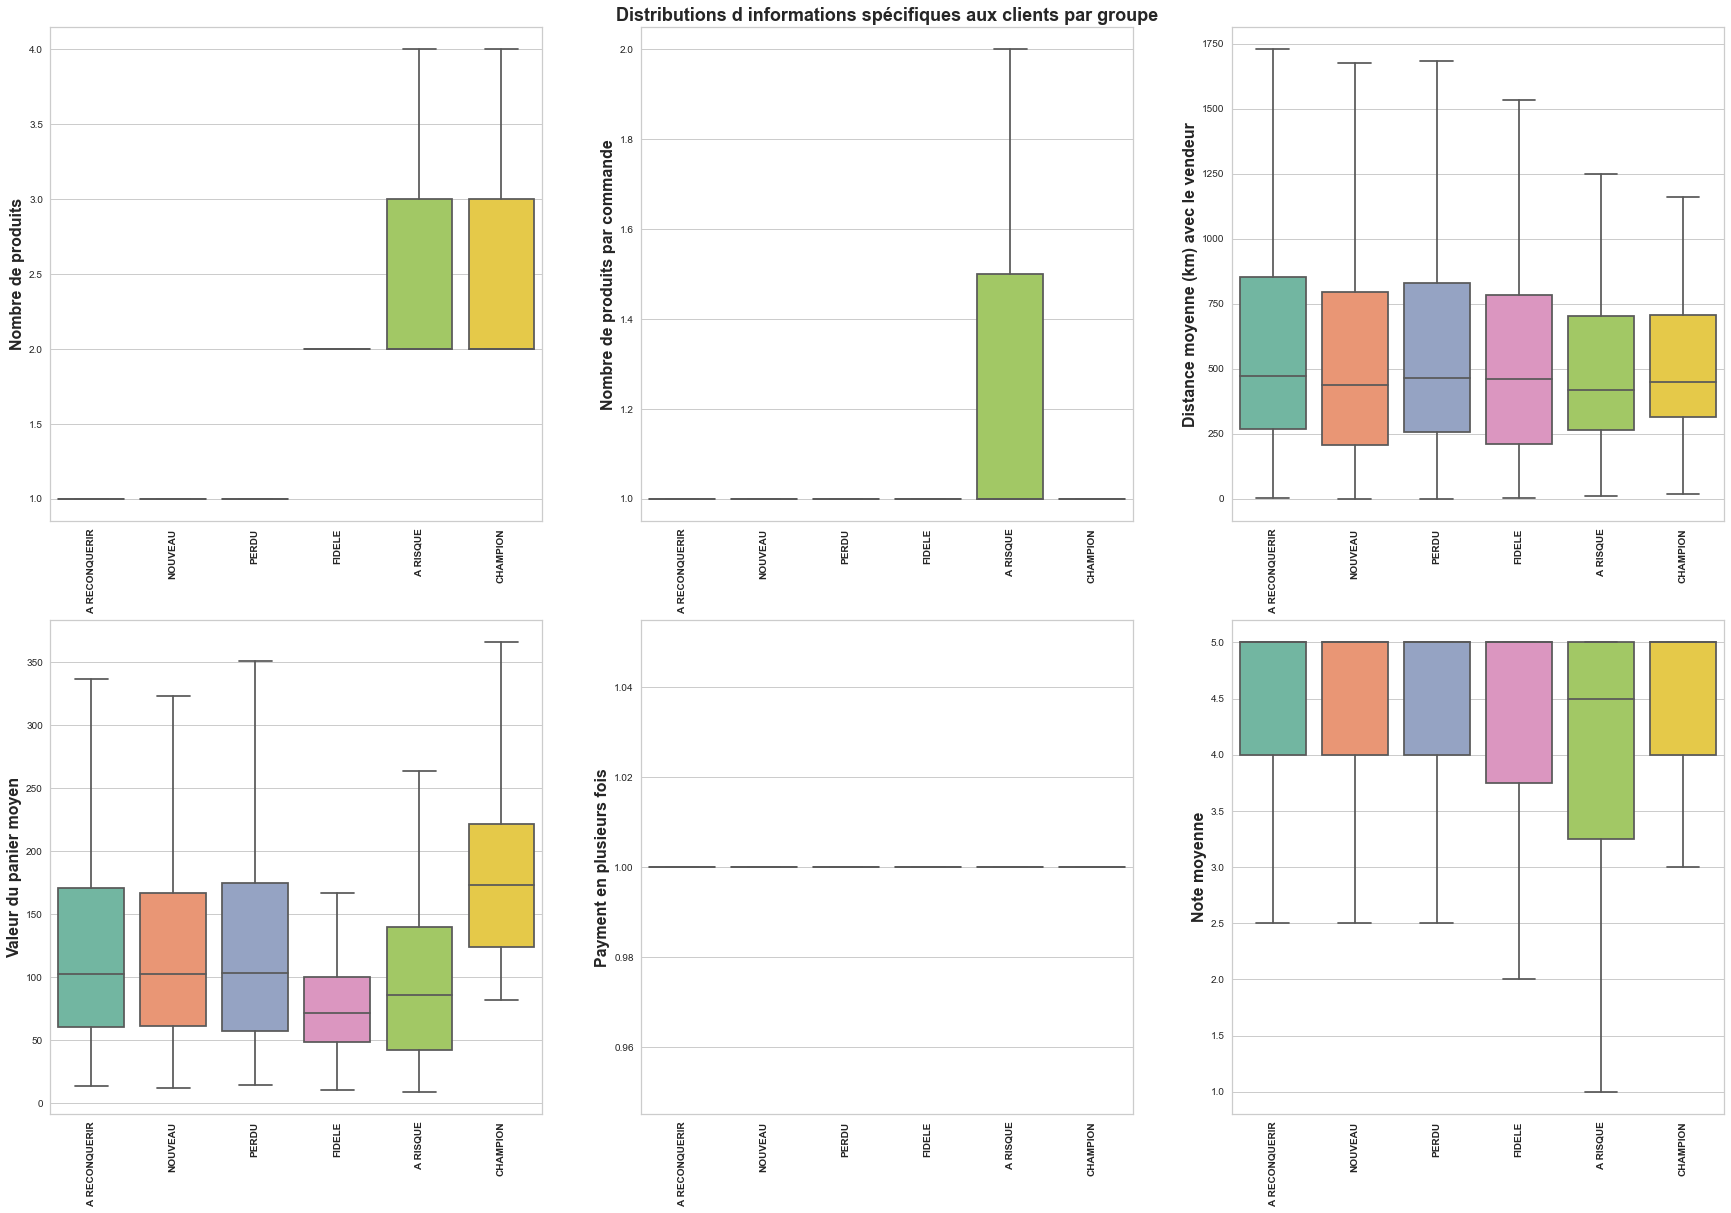

In [24]:
boxplot_specific_customer_infos_by_group(
    df_data_RFM_period, df_result_rfm, 'RFM_segment', color_segment)

--> Champion payed more than the others <br/>
--> A risque have more product by order than the other and seems to have the less notes values <br/>
--> A risque and champion have ordered in average more product

#### Function to focus on specific products informations by segment (or cluster)

In [25]:
def products_infos_cluster(df_data, df_customer, df_cluster_result, column_cluster, colors):
    '''Function to evaluate some basic products informations by cluster
    df_data --> global file from olist database
    df_customer --> aggregate data per customer
    df_clust_result --> aggregate data by cluster
    column_cluster --> column to find cluster attribution
    colors --> colorsmap for the clustering'''
    df_data_period_cluster = pd.merge(df_data,
                                      df_customer[column_cluster], right_index=True, left_on='customer_unique_id', how='left')
    df_product_infos = df_data_period_cluster.groupby(column_cluster).agg(nb_tot_prod=('product_id', pd.Series.count),
                                                                          nb_tot_order=(
        'order_id', pd.Series.nunique),
        best_prod=(
        'product_id', lambda x: x.value_counts().index[0]),
        best_seller=(
        'seller_id', lambda x: x.value_counts().index[0]),
        main_cat=('category_name', lambda x: x.value_counts().index[0]))
    df_product_infos = df_product_infos.reindex(df_cluster_result.index)

    for name in df_product_infos.index:
        print(f'Pour le groupe {name}:')
        print(
            f'- L article le plus vendu --> {df_product_infos.best_prod[name]}')
        print(
            f'- Le vendeur le plus sollicité --> {df_product_infos.best_seller[name]}')
        print(
            f'- La catégorie la plus achetée --> {df_product_infos.main_cat[name]}')
        print('_ '*40)

    figure_pie = plt.figure(figsize=(25, 10), facecolor='w')
    plt.title(
        f'Informations produits suivant leur groupe', pad=80, fontweight='bold', fontsize=18)
    plt.axis('off')
    count = 1
    for name in ['nb_tot_prod', 'nb_tot_order']:
        x = df_product_infos[name]
        figure_pie.add_subplot(1, 2, count)
        plt.title(f'Répartition {name} par groupes',
                  fontweight='bold', fontsize=14)
        expl = [0 if i/x.sum() > 0.02 else 0.5 for i in x]
        plt.pie(x, labels=[i for i in x.index], autopct="%.1f%%", pctdistance=0.8,
                explode=expl, textprops={'fontsize': 10, 'fontweight': 'bold'}, colors=colors)
        count += 1
    plt.show()
    return df_product_infos

Pour le groupe A RECONQUERIR:
- L article le plus vendu --> 99a4788cb24856965c36a24e339b6058
- Le vendeur le plus sollicité --> 4a3ca9315b744ce9f8e9374361493884
- La catégorie la plus achetée --> bed_bath_table
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Pour le groupe NOUVEAU:
- L article le plus vendu --> 42a2c92a0979a949ca4ea89ec5c7b934
- Le vendeur le plus sollicité --> 7a67c85e85bb2ce8582c35f2203ad736
- La catégorie la plus achetée --> bed_bath_table
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Pour le groupe PERDU:
- L article le plus vendu --> 7e0dc102074f8285580c9777f79c90cf
- Le vendeur le plus sollicité --> cca3071e3e9bb7d12640c9fbe2301306
- La catégorie la plus achetée --> furniture_decor
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Pour le groupe FIDELE:
- L article le plus vendu --> d5991653e037ccb7af6ed7d94246b249
- Le vendeur le plus sollicité --> 4a3ca9315b744ce9

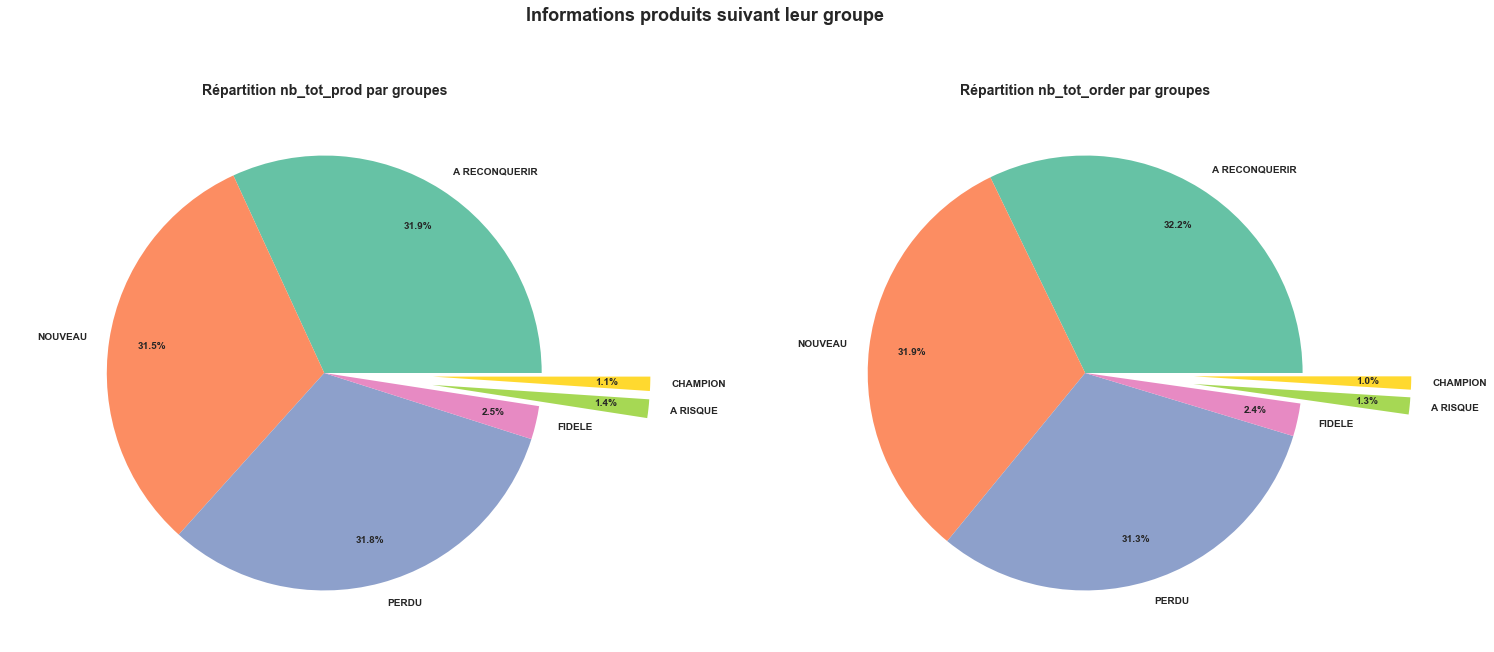

nb_tot_prod  nb_tot_order                         best_prod  \
RFM_segment                                                                  
A RECONQUERIR         4887          4376  99a4788cb24856965c36a24e339b6058   
NOUVEAU               4827          4336  42a2c92a0979a949ca4ea89ec5c7b934   
PERDU                 4870          4250  7e0dc102074f8285580c9777f79c90cf   
FIDELE                 380           332  d5991653e037ccb7af6ed7d94246b249   
A RISQUE               212           172  7c68e7297c7df2535c9f0dcd61007f64   
CHAMPION               162           133  7a82832901d5f4cd314a4e102c47bd2b   

                                    best_seller         main_cat  
RFM_segment                                                       
A RECONQUERIR  4a3ca9315b744ce9f8e9374361493884   bed_bath_table  
NOUVEAU        7a67c85e85bb2ce8582c35f2203ad736   bed_bath_table  
PERDU          cca3071e3e9bb7d12640c9fbe2301306  furniture_decor  
FIDELE         4a3ca9315b744ce9f8e9374361493884   bed_bath_table  
A RISQUE       cca3071e3e9bb7d12640c9fbe2301306  furniture_decor  
CHAMPION       4a3ca9315b744ce9f8e9374361493884   bed_bath_table

In [26]:
products_infos_cluster(df_data_global_olist_period, df_data_RFM_period,
                       df_result_rfm, 'RFM_segment', colors=color_segment)

### **Evaluation of the customer in time via Sankey diagram (BONUS)**

--> import data done on different periods (for test purpose)

In [78]:
df_compare_data = pd.read_csv('test_sankey_data.csv', index_col=0)
df_compare_data1 = df_compare_data.dropna(subset=['RFM_segment_x']).copy()

In [79]:
df_sankey = pd.DataFrame(
    [], columns=df_compare_data1['RFM_segment_y'].unique())
for group in df_compare_data1['RFM_segment_x'].unique():
    series_group = df_compare_data1.loc[df_compare_data1['RFM_segment_x']
                                        == group]['RFM_segment_y'].value_counts()
    series_group.name = group
    df_sankey = df_sankey.append(series_group)

df_sankey = df_sankey.fillna(0)

df_sankey

PERDU  A RISQUE  CHAMPION  FIDELE
PERDU           3983       5.0      13.0    26.0
A RECONQUERIR   3934       3.0      15.0    44.0
NOUVEAU         3988       2.0      29.0    53.0
A RISQUE           0      62.0       0.0     0.0
FIDELE             0     103.0       1.0     2.0
CHAMPION           0      66.0       0.0     2.0

In [80]:
df_count_segment = df_compare_data.groupby(
    ['RFM_segment_x', 'RFM_segment_y'], as_index=False, dropna=False).size()
df_count_segment.rename(columns={'size': 'number'}, inplace=True)
df_count_segment

RFM_segment_x  RFM_segment_y  number
0   A RECONQUERIR       A RISQUE       3
1   A RECONQUERIR       CHAMPION      15
2   A RECONQUERIR         FIDELE      44
3   A RECONQUERIR          PERDU    3934
4        A RISQUE       A RISQUE      62
5        CHAMPION       A RISQUE      66
6        CHAMPION         FIDELE       2
7          FIDELE       A RISQUE     103
8          FIDELE       CHAMPION       1
9          FIDELE         FIDELE       2
10        NOUVEAU       A RISQUE       2
11        NOUVEAU       CHAMPION      29
12        NOUVEAU         FIDELE      53
13        NOUVEAU          PERDU    3988
14          PERDU       A RISQUE       5
15          PERDU       CHAMPION      13
16          PERDU         FIDELE      26
17          PERDU          PERDU    3983
18            NaN  A RECONQUERIR   13558
19            NaN       A RISQUE      68
20            NaN       CHAMPION     234
21            NaN         FIDELE     425
22            NaN        NOUVEAU   13606
23            NaN          PERDU    1630

In [81]:
colorPalette = ['#4B8BBE', '#306998', '#FFE873', '#FFD43B', '#646464']
labelList = []
colorNumList = []
value_cols = 'number'
cat_cols = ['RFM_segment_x', 'RFM_segment_y']
for catCol in df_count_segment.iloc[:, :-1].columns:
    labelListTemp = list(set(df_count_segment[catCol].values))
    # drop nan values in labelListTemp
    labelListTemp = [
        name for name in labelListTemp if pd.isnull(name) == False]
    colorNumList.append(len(labelListTemp))
    labelList = labelList + labelListTemp

In [82]:
for i in range(len(cat_cols)-1):
    if i == 0:
        sourceTargetDf = df_count_segment[[
            cat_cols[i], cat_cols[i+1], value_cols]]
        sourceTargetDf.columns = ['source', 'target', 'count']
    else:
        tempDf = df_count_segment[[cat_cols[i], cat_cols[i+1], value_cols]]
        tempDf.columns = ['source', 'target', 'count']
        sourceTargetDf = pd.concat([sourceTargetDf, tempDf])

    # add index for source-target pair and avoid nan value if present
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(
        lambda x: labelList.index(x) if pd.isnull(x) == False else -1)
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(
        lambda x: (labelList.index(x) + 6) if pd.isnull(x) == False else -1)

    source = sourceTargetDf.loc[sourceTargetDf['sourceID'] != -1]['sourceID']
    target = sourceTargetDf.loc[sourceTargetDf['targetID'] != -1]['targetID']
    value = sourceTargetDf['count']

In [83]:
sourceTargetDf

source         target  count  sourceID  targetID
0   A RECONQUERIR       A RISQUE      3         0        11
1   A RECONQUERIR       CHAMPION     15         0        10
2   A RECONQUERIR         FIDELE     44         0         9
3   A RECONQUERIR          PERDU   3934         0         7
4        A RISQUE       A RISQUE     62         5        11
5        CHAMPION       A RISQUE     66         4        11
6        CHAMPION         FIDELE      2         4         9
7          FIDELE       A RISQUE    103         3        11
8          FIDELE       CHAMPION      1         3        10
9          FIDELE         FIDELE      2         3         9
10        NOUVEAU       A RISQUE      2         2        11
11        NOUVEAU       CHAMPION     29         2        10
12        NOUVEAU         FIDELE     53         2         9
13        NOUVEAU          PERDU   3988         2         7
14          PERDU       A RISQUE      5         1        11
15          PERDU       CHAMPION     13         1        10
16          PERDU         FIDELE     26         1         9
17          PERDU          PERDU   3983         1         7
18            NaN  A RECONQUERIR  13558        -1         6
19            NaN       A RISQUE     68        -1        11
20            NaN       CHAMPION    234        -1        10
21            NaN         FIDELE    425        -1         9
22            NaN        NOUVEAU  13606        -1         8
23            NaN          PERDU   1630        -1         7

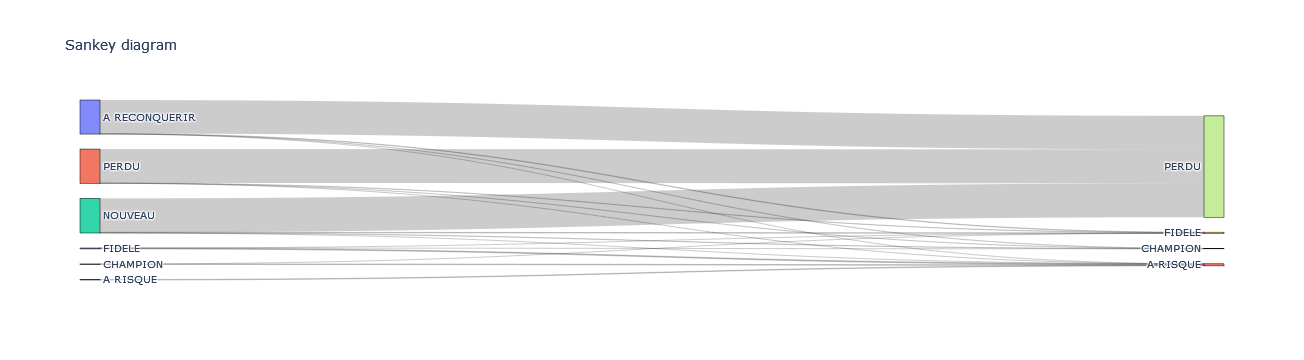

In [84]:
import plotly.graph_objects as go
link = dict(source=source, target=target, value=value)
node = dict(label=labelList, pad=35, thickness=10)
data = dict(
    type='sankey', hoverinfo='all',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(
            color="black",
            width=0.5
        ),
        label=labelList,
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)
layout = dict(
    title='Sankey diagram',
    font=dict(
        size=10
    )
)

fig = dict(data=[data], layout=layout)

figure = go.Figure(fig)
figure.show()

--> need more time to use same color and try more than 2 periods!!

## **II - Clustering models (RFM+ on the same period as the RFM study)**

### **A) Data-prepocessing: Re-use our data use with RFM and adding our 3 variables**

--> we are adding 'nb_prod_by_order', 'mean_payment_by_order', 'mean_shipping_delay_days'

In [27]:
df_data_models = df_data_RFM_period[[
    'R', 'F', 'M', 'nb_prod_by_order', 'mean_payment_by_order', 'mean_shipping_delay_days']].copy()
df_data_RFM_period

R  F       M             main_prod_cat  \
customer_unique_id                                                           
0000f46a3911fa3c0805444483337064  111  1   86.22                stationery   
0005e1862207bf6ccc02e4228effd9a0  116  1  150.12  fashion_bags_accessories   
00115fc7123b5310cf6d3a3aa932699e  159  1   76.11            sports_leisure   
0011805441c0d1b68b48002f1d005526   66  1  297.14     computers_accessories   
0011857aff0e5871ce5eb429f21cdaf5    1  1  192.83       luggage_accessories   
...                               ... ..     ...                       ...   
ffebb6424578e7bb153322da9d65634f  164  1  665.70                cool_stuff   
ffedff0547d809c90c05c2691c51f9b7   91  1   32.42                housewares   
ffef0ffa736c7b3d9af741611089729b   31  1  139.07            sports_leisure   
ffff371b4d645b6ecea244b27531430a  142  1  112.46                      auto   
ffffd2657e2aad2907e67c3e9daecbeb   58  1   71.56                 perfumery   

                                  nb_prod  nb_prod_by_order  \
customer_unique_id                                            
0000f46a3911fa3c0805444483337064      1.0               1.0   
0005e1862207bf6ccc02e4228effd9a0      1.0               1.0   
00115fc7123b5310cf6d3a3aa932699e      1.0               1.0   
0011805441c0d1b68b48002f1d005526      1.0               1.0   
0011857aff0e5871ce5eb429f21cdaf5      1.0               1.0   
...                                   ...               ...   
ffebb6424578e7bb153322da9d65634f      1.0               1.0   
ffedff0547d809c90c05c2691c51f9b7      1.0               1.0   
ffef0ffa736c7b3d9af741611089729b      1.0               1.0   
ffff371b4d645b6ecea244b27531430a      1.0               1.0   
ffffd2657e2aad2907e67c3e9daecbeb      1.0               1.0   

                                                        top_seller  \
customer_unique_id                                                   
0000f46a3911fa3c0805444483337064  3d871de0142ce09b7081e2b9d1733cb1   
0005e1862207bf6ccc02e4228effd9a0  0cbcee27c791afa0cdcb08587a2013a8   
00115fc7123b5310cf6d3a3aa932699e  54a1852d1b8f10312c55e906355666ee   
0011805441c0d1b68b48002f1d005526  96493fab2fbb13a14d0c0e8772eef5c3   
0011857aff0e5871ce5eb429f21cdaf5  9d5a9018aee56acb367ba9c3f05d1d6a   
...                                                            ...   
ffebb6424578e7bb153322da9d65634f  dc317f341ab0e22f39acbd9dbf9b4a1f   
ffedff0547d809c90c05c2691c51f9b7  dd2bdf855a9172734fbc3744021ae9b9   
ffef0ffa736c7b3d9af741611089729b  c3cfdc648177fdbbbb35635a37472c53   
ffff371b4d645b6ecea244b27531430a  54aa8463e87776b5612f4bdc4bd5d4de   
ffffd2657e2aad2907e67c3e9daecbeb  cc419e0650a3c5ba77189a1882b7556a   

                                  mean_seller_dist_km  \
customer_unique_id                                      
0000f46a3911fa3c0805444483337064           517.883143   
0005e1862207bf6ccc02e4228effd9a0           245.860181   
00115fc7123b5310cf6d3a3aa932699e           774.662274   
0011805441c0d1b68b48002f1d005526          2211.443664   
0011857aff0e5871ce5eb429f21cdaf5           819.508679   
...                                               ...   
ffebb6424578e7bb153322da9d65634f           857.245703   
ffedff0547d809c90c05c2691c51f9b7           425.655874   
ffef0ffa736c7b3d9af741611089729b          1185.417662   
ffff371b4d645b6ecea244b27531430a          1527.160181   
ffffd2657e2aad2907e67c3e9daecbeb           356.318489   

                                  mean_shipping_delay_days  \
customer_unique_id                                           
0000f46a3911fa3c0805444483337064                      25.0   
0005e1862207bf6ccc02e4228effd9a0                       4.0   
00115fc7123b5310cf6d3a3aa932699e                      10.0   
0011805441c0d1b68b48002f1d005526                      18.0   
0011857aff0e5871ce5eb429f21cdaf5                       8.0   
...                                                    ...   
ffebb6424578e7bb153322da9d65634f                    

--> Visualization of our data before preprocessing

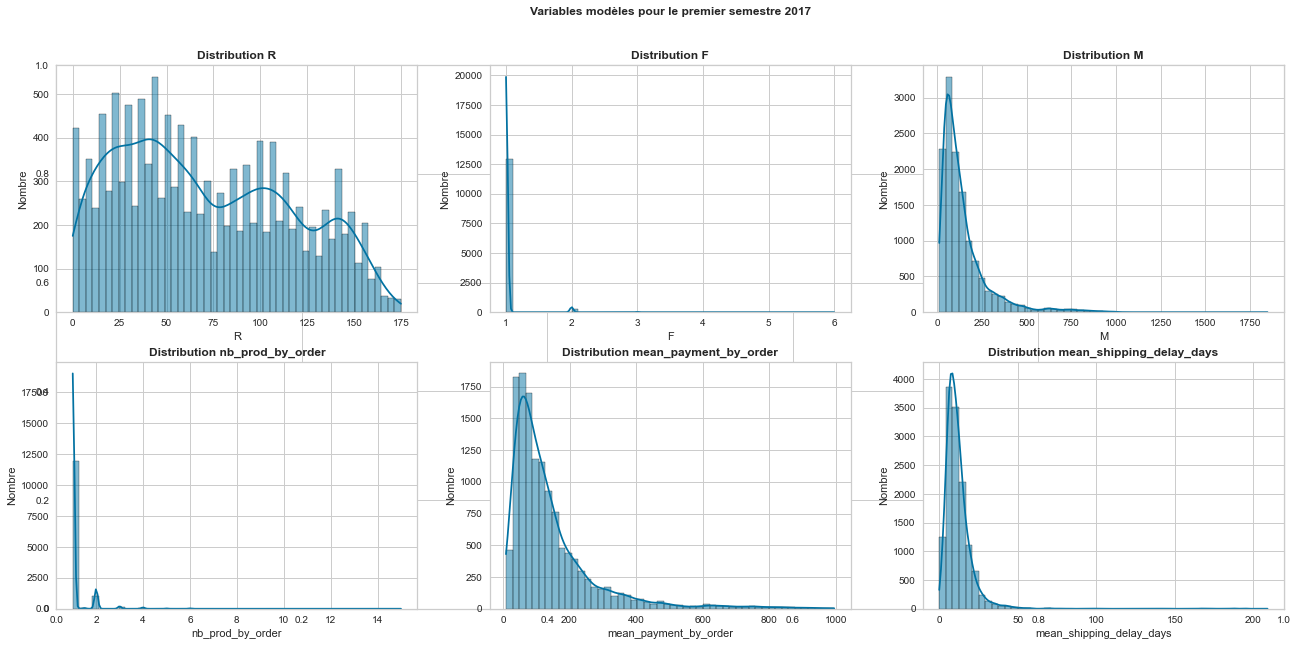

In [28]:
figure_4 = plt.figure(figsize=(22, 10))
count = 1
plt.title('Variables modèles pour le premier semestre 2017',
          fontweight='bold', pad=50)
for name in df_data_models.columns:
    figure_4.add_subplot(2, 3, count)
    plt.title(f'Distribution {name}', fontweight='bold')
    sns.histplot(data=df_data_models[name], bins=50, kde=True)
    plt.ylabel('Nombre')
    count += 1
plt.savefig('variables before preprocessing.jpg', dpi=300, bbox_inches='tight')
plt.show()

--> five variables could be passed to the log + 1 : F,M, 'nb_prod_by_order', 'mean_payment_by_order', 'mean_shipping_delay_days'] before applying a standard scaler

In [29]:
list_log_v = ['F', 'M', 'nb_prod_by_order',
              'mean_payment_by_order', 'mean_shipping_delay_days']

#### Function to focus on specifics customers informations by segment (or cluster)

In [30]:
def preprocessing_custom_log1(df_data, log_list):
    '''Custom function to preprocess (log transformation + standardization)
    enter a list of variables to pass to the log
    It returns our dataset transform'''
    # log transformation
    df_model = df_data.copy()
    df_model[log_list] = df_model[log_list].apply(np.log1p, axis=1)
    # Standardization
    std_Sc = StandardScaler()
    std_Sc.fit(df_model)
    std_transform = std_Sc.transform(df_model)
    df_model = pd.DataFrame(
        data=std_transform, columns=df_model.columns, index=df_model.index)
    return df_model

--> Transformation and visualization before model training

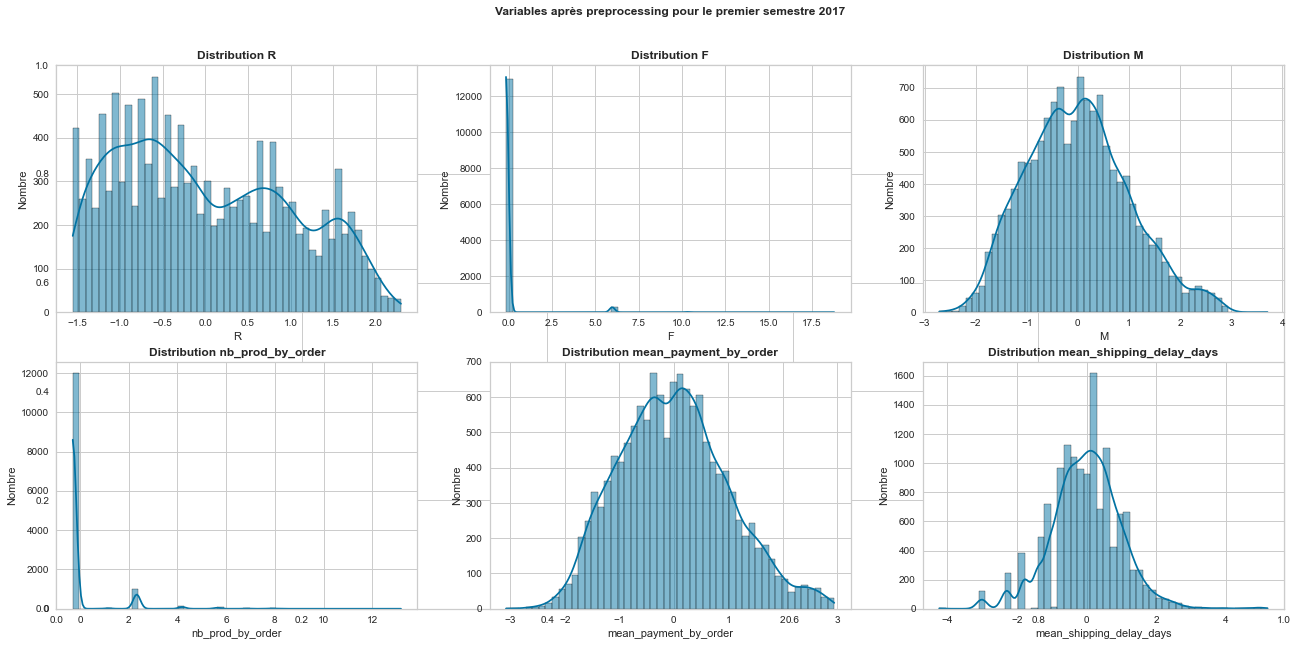

In [31]:
df_data_models_std = preprocessing_custom_log1(
    df_data_models, list_log_v)

figure_5 = plt.figure(figsize=(22, 10))
count = 1
plt.title('Variables après preprocessing pour le premier semestre 2017',
          fontweight='bold', pad=50)
for name in df_data_models_std.columns:
    figure_5.add_subplot(2, 3, count)
    plt.title(f'Distribution {name}', fontweight='bold')
    sns.histplot(data=df_data_models_std[name], bins=50, kde=True)
    plt.ylabel('Nombre')
    count += 1
plt.savefig('variables after preprocessing.jpg', dpi=300, bbox_inches='tight')
plt.show()

### **B) K-means model**

#### algoritm train and elbow method to find the best cluster number

<AxesSubplot:title={'center':'Yellowbricks: Inertia du modele en fonction du nombre K de cluster'}, xlabel='k', ylabel='distortion score'>

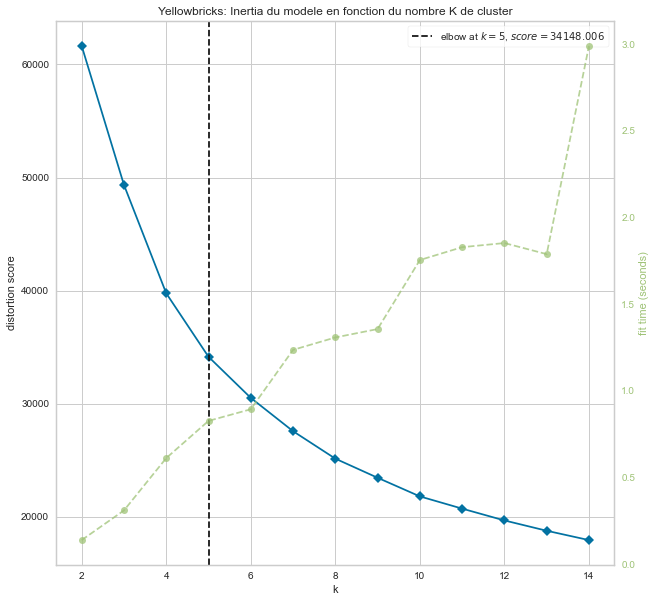

In [32]:
X = df_data_models_std
kmeans_model = KMeans()

figure_6 = plt.figure(figsize=(10, 10), facecolor='w')
visualizer = KElbowVisualizer(kmeans_model, k=(
    2, 15), title='Yellowbricks: Inertia du modele en fonction du nombre K de cluster')
visualizer.fit(X)
visualizer.show(outpath='yellowbricks_kmeans_elbow.jpg')

#### Silhouette score method to find the best cluster number

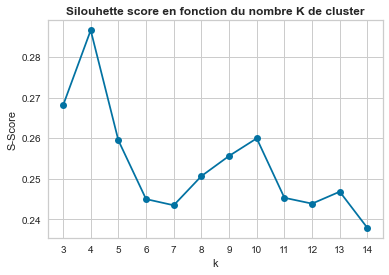

In [33]:
list_silh_score = list()
for k in range(3, 15):
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(X)
    list_silh_score.append(metrics.silhouette_score(
        X, kmeans_model.predict(X)))

plt.title('Silouhette score en fonction du nombre K de cluster',
          fontweight='bold')
plt.plot(range(3, 15), list_silh_score, 'o-')
plt.xticks(range(3, 15))
plt.xlabel('k')
plt.ylabel('S-Score')
plt.show()

--> this methods take more time than the other <br/>
--> let's try results find with the elbow methods n_cluster = 5

#### Training model with 5 clusters

In [34]:
kmeans_model = KMeans(n_clusters=5)
kmeans_model.fit(X)

KMeans(n_clusters=5)

--> let's try visualization of our cluster with dimension reduction

#### Functions to have different visualization (2D and 3D dimension reductions for Kmeans models)

--> 2D visualization with PCA

In [35]:
def cluster2D_PCA_viz(data, cluster_model, savefig=False):
    '''Function to vizualise the result of clustering model in 2D via PCA.
    Be careful the data must be standardized(normaly if kmeans method have
    been used for the clustering model it is already done)
    data must be a dataframe
    cluster model should be a train model
    decomposition and kmeans module from sklearn should be loaded
    figure can be saved (default False)'''

    print(f'data shape are {data.shape}')
    # pca model implementation
    pca = decomposition.PCA(n_components=2)
    pca.fit(data)
    print(
        f'PCA in 2 dimension explain {pca.explained_variance_ratio_.sum()*100: .2f} % of the variance of our input data')
    data_projected = pca.transform(data)

    # transformation of model centroid coordinate with PCA model
    centroids_PCA = pca.transform(cluster_model.cluster_centers_)

    # visualization scatter plot with cluster and centroid representation and component contribution
    pcs = pca.components_
    figure1 = plt.figure(figsize=(20, 10))
    plt.rcParams.update({'font.size': 12})
    figure1.add_subplot(1, 2, 1)
    plt.title('Variables projected on the two principal components of our PCA',
              fontweight='bold', pad=20)
    a = plt.scatter(data_projected[:, 0], data_projected[:, 1],
                    c=cluster_model.predict(data), cmap='viridis')
    b = plt.scatter(centroids_PCA[:, 0],
                    centroids_PCA[:, 1], marker='^', c='red')
    plt.legend(*a.legend_elements(), title='Clusters:')
    plt.xlabel(
        f'PC1 (explained variance {pca.explained_variance_ratio_[0]*100:.2f} %)')
    plt.ylabel(
        f'PC2 (explained variance {pca.explained_variance_ratio_[1]*100:.2f} %)')
    figure1.add_subplot(1, 2, 2)
    plt.title('Components contribution in our PCA', fontweight='bold', pad=20)
    for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
        plt.plot([0, x], [0, y], c='k')
        plt.text(x, y, data.columns[i])
    plt.xlabel(
        f'PC1 (explained variance {pca.explained_variance_ratio_[0]*100:.2f} %)')
    plt.ylabel(
        f'PC2 (explained variance {pca.explained_variance_ratio_[1]*100:.2f} %)')
    if savefig == True:
        plt.savefig(f'PCA_2D_viz.jpg', dpi=300, bbox_inches='tight')
    else:
        print('figure not saved')
    plt.show()

--> 3D visualization with PCA

In [37]:
def cluster3D_PCA_viz(data, cluster_model, savefig=False):
    '''Function to vizualise the result of clustering model in 3D via PCA.
    Be careful the data must be standardized(normaly if kmeans method have
    been used for the clustering model it is already done)
    data must be a dataframe
    cluster model should be a train model
    decomposition and kmeans module from sklearn should be loaded. Saving the figure is possible via savefig parameters (False by default)
    the model return the color of the cluster'''

    print(f'data shape are {data.shape}')
    pca = decomposition.PCA(n_components=3, random_state=0)
    pca.fit(data)
    print(
        f'PCA in 2 dimension explain {pca.explained_variance_ratio_.sum()*100: .2f} % of the variance of our input data')
    data_projected = pca.transform(data)

    # transformation of model centroid coordinate with PCA model
    centroids_PCA = pca.transform(cluster_model.cluster_centers_)

    # visualization3D scatter plot with cluster and centroid representation and components contribution
    pcs = pca.components_
    figure_3D = plt.figure(figsize=(25, 10))
    plt.title('Variables projected on the 3 principal components of our PCA and their contributions ',
              loc='center', fontweight='bold')
    plt.axis('off')
    ax = figure_3D.add_subplot(1, 2, 1, projection='3d')
    a = ax.scatter(data_projected[:, 0], data_projected[:, 1], data_projected[:, 2],
                   c=cluster_model.predict(data), cmap='viridis')
    b = ax.scatter(centroids_PCA[:, 0],
                   centroids_PCA[:, 1], centroids_PCA[:, 2], marker='^', c='red')

    plt.legend(*a.legend_elements(), title='Clusters:')
    ax.set_xlabel(
        f'PC1 (explained variance {pca.explained_variance_ratio_[0]*100:.2f} %)')
    ax.set_ylabel(
        f'PC2 (explained variance {pca.explained_variance_ratio_[1]*100:.2f} %)')
    ax.set_zlabel(
        f'PC3 (explained variance {pca.explained_variance_ratio_[2]*100:.2f} %)')
    ax.view_init(30, 35)

    ax2 = figure_3D.add_subplot(1, 2, 2, projection='3d')
    for i, (x, y, z) in enumerate(zip(pcs[0, :], pcs[1, :], pcs[2, :])):
        ax2.plot([0, x], [0, y], [0, z], c='k')
        ax2.text(x, y, z, data.columns[i])
    ax2.set_xlabel(
        f'PC1 (explained variance {pca.explained_variance_ratio_[0]*100:.2f} %)')
    ax2.set_ylabel(
        f'PC2 (explained variance {pca.explained_variance_ratio_[1]*100:.2f} %)')
    ax2.set_zlabel(
        f'PC3 (explained variance {pca.explained_variance_ratio_[2]*100:.2f} %)')
    ax2.view_init(30, 35)
    if savefig == True:
        plt.savefig('PCA_3D_viz_cluster_model.jpg',
                    dpi=300, bbox_inches='tight')
    else:
        print('figure not saved')
    plt.show()
    model_color = [element.get_color()
                   for element in a.legend_elements('colors')[0]]
    return model_color

--> 2D visualization with tSNE

In [38]:
def cluster_2D_TSNE_viz(data, cluster_model, savefig=False, comment=''):
    '''Function to represent in 2D cluster distribution via TSNE transformation
    manifold library should be imported
    comment --> use this to add specific comment to the name of the file if saved
    '''

    tsne_red = manifold.TSNE(n_components=2, perplexity=30, n_jobs=-1, random_state=0)
    data_tsne_projected = tsne_red.fit_transform(data)
    figure_tsne = plt.figure(figsize=(10, 10))
    plt.title('TSNE two dimension reduction of our data with cluster color')
    a = plt.scatter(data_tsne_projected[:, 0], data_tsne_projected[:, 1],
                    c=cluster_model.labels_, cmap='viridis')
    plt.legend(*a.legend_elements(), title='Clusters:')
    if savefig == True:
        plt.savefig(f'TSNE_2D_viz_cluster_model_{comment}.jpg', dpi=300)
    else:
        print('figure not saved')
    plt.show()

#### Visualizations

data shape are (13266, 6)
PCA in 2 dimension explain  52.51 % of the variance of our input data


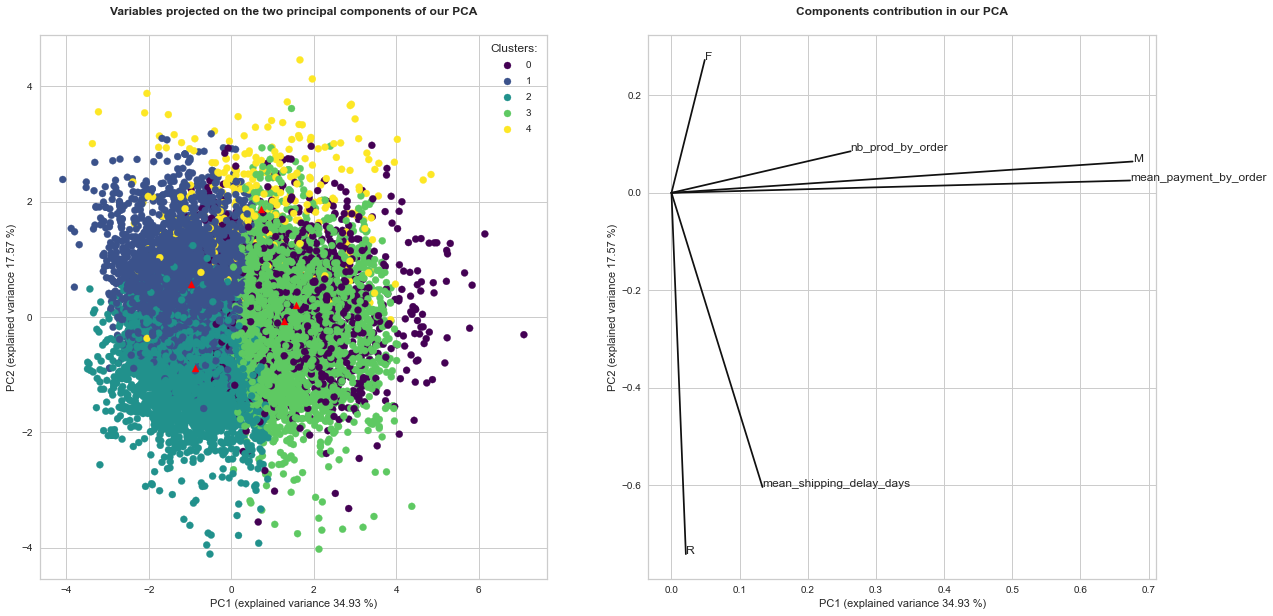

In [39]:
cluster2D_PCA_viz(X, kmeans_model, savefig=True)

data shape are (13266, 6)
PCA in 2 dimension explain  69.31 % of the variance of our input data


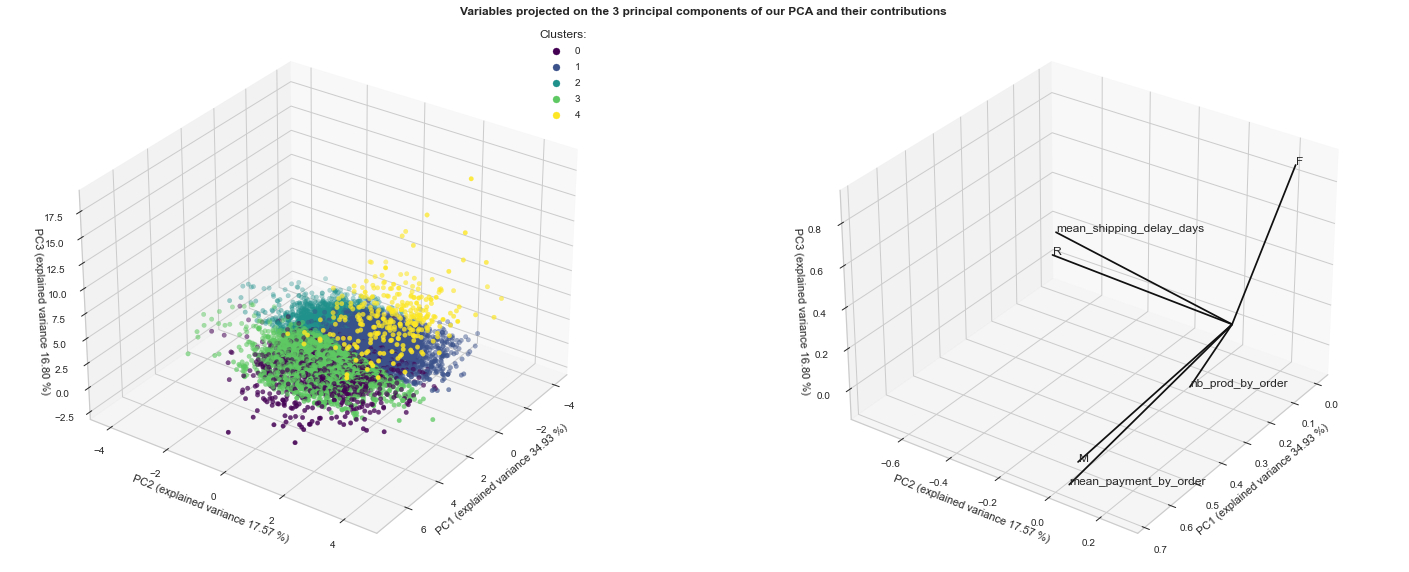

In [40]:
kmeans_model_colors = cluster3D_PCA_viz(X, kmeans_model, savefig=True)

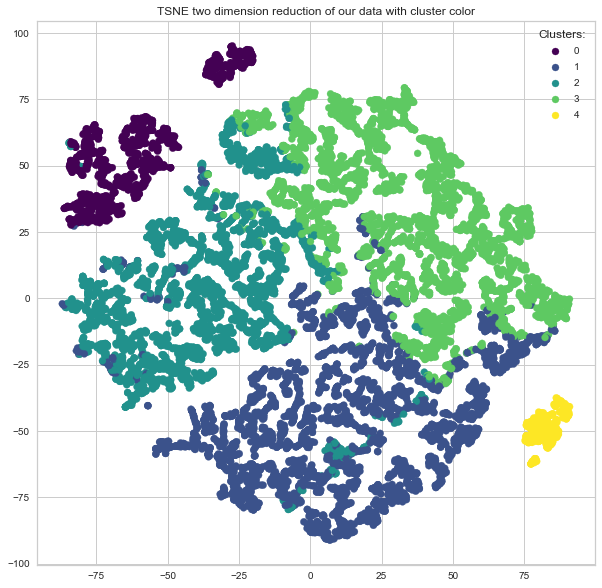

In [56]:
cluster_2D_TSNE_viz(X, kmeans_model, savefig=True,
                    comment='kmeans_model_5_clusters')

#### K-means clustering silouhette score visualization (with 5 clusters)

<AxesSubplot:title={'center':'Yellowbricks: Silouhette score visualisation pour notre modele kmean à 5 cluster'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

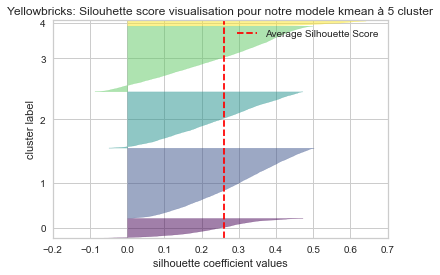

In [57]:
visualizer = SilhouetteVisualizer(kmeans_model, colors=kmeans_model_colors,
                                  title='Yellowbricks: Silouhette score visualisation pour notre modele kmean à 5 cluster')
visualizer.fit(X)
visualizer.show(outpath='Silhouette score visualization kmeans.jpg')

#### Metrics evaluation

In [42]:
tab_result = pd.DataFrame(
    [], columns=['Model', 'Parameter_nb_cluster', 'Davies_boulin_score', 'Silhouette_score'])

# Function to add result to our dataframe results
def metrics_clusters(data, nb_clusters, cluster_model, model_name, tab_result):
    '''Function create a Series of metrics for a model input with its data'''
    row = pd.Series(data={'Model': model_name, 'Parameter_nb_cluster': nb_clusters, 'Davies_boulin_score': metrics.davies_bouldin_score(
        data, cluster_model.labels_), 'Silhouette_score': metrics.silhouette_score(data, cluster_model.labels_)}, name=len(tab_result))
    tab_result = tab_result.append(row)
    return tab_result

tab_result = metrics_clusters(X, 5, kmeans_model, 'Kmeans model', tab_result)
tab_result

Model Parameter_nb_cluster  Davies_boulin_score  Silhouette_score
0  Kmeans model                    5             1.122214          0.259282

### **C) DBSCAN model (using the same data as Kmeans model)**

#### algoritm train and trying to reduce the noise points (cluster -1) to find an optimum

--> min_sample is set to 6, the number of our varibales

In [43]:
noise_list = list()
n_clusters_list = list()
# loop on epsilon
for epsi in np.arange(0.5, 2.6, 0.1):
    epsi = np.round(epsi, decimals=1)
    dbscan_model_0 = DBSCAN(eps=epsi, min_samples=6)
    dbscan_model_0.fit(X)
    labels = dbscan_model_0.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_dbscan = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    # append n_cluster and n_noise to lists for epsi
    noise_list.append(n_noise)
    n_clusters_list.append(n_clusters_dbscan)

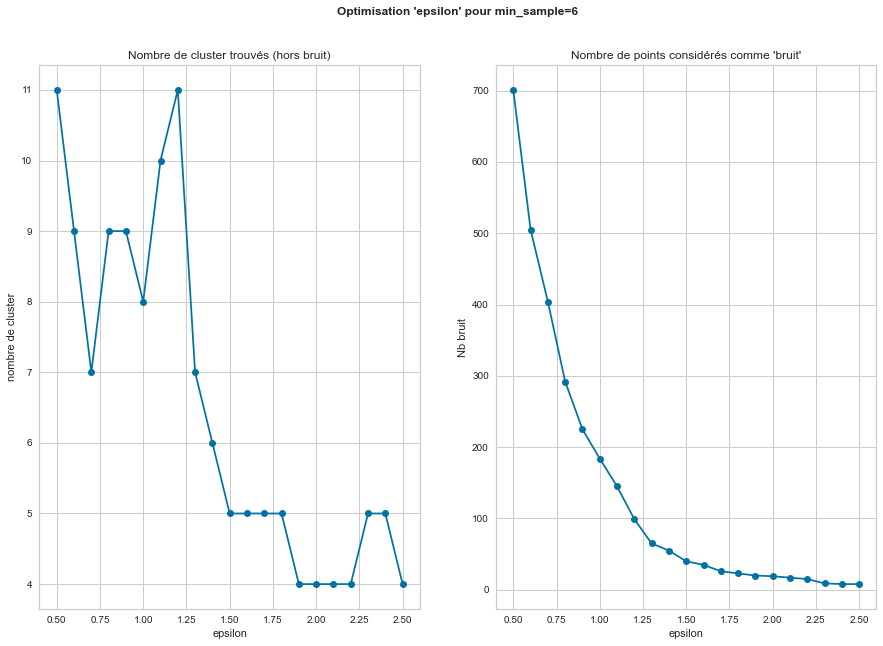

In [44]:
# Graph number of cluster and number of noise points for each epsi
figure_DBSCAN_opti = plt.figure(figsize=(15, 10))
plt.title("Optimisation 'epsilon' pour min_sample=6",
          fontweight='bold',  pad=50)
plt.axis('off')
figure_DBSCAN_opti.add_subplot(1, 2, 1)
plt.title('Nombre de cluster trouvés (hors bruit)')
plt.plot(np.arange(0.5, 2.6, 0.1), n_clusters_list, 'o-')
plt.xlabel('epsilon')
plt.ylabel('nombre de cluster')
figure_DBSCAN_opti.add_subplot(1, 2, 2)
plt.title("Nombre de points considérés comme 'bruit'")
plt.plot(np.arange(0.5, 2.6, 0.1), noise_list, 'o-')
plt.xlabel('epsilon')
plt.ylabel("Nb bruit")
plt.savefig('DBSCAN_optimisation.jpg', dpi=300, bbox_inches='tight')
plt.show()

--> not sure of our technic of optimization <br/>
--> let's try a DBSCAN with eps at 2.5 and min sample at 6 (to have 4 clusters)

#### Training model with epsilon=2.5 and min_samples=6

In [45]:
dbscan_model = DBSCAN(eps=2.5, min_samples=6)
dbscan_model.fit(X)

DBSCAN(eps=2.5, min_samples=6)

#### Visualizations

PCA in 2 dimension explain  52.51 % of the variance of our input data


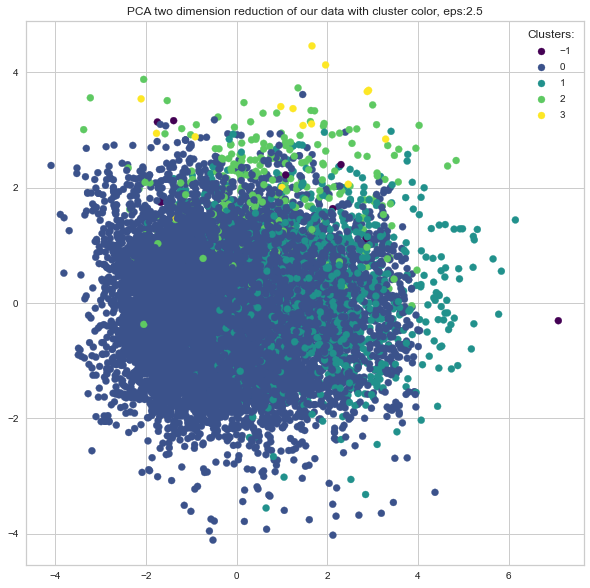

In [46]:
# PCA 2D viz
pca = decomposition.PCA(n_components=2)
pca.fit(X)
print(
    f'PCA in 2 dimension explain {pca.explained_variance_ratio_.sum()*100: .2f} % of the variance of our input data')
data_projected = pca.transform(X)
figure_PCA = plt.figure(figsize=(10, 10))
plt.title(
    f'PCA two dimension reduction of our data with cluster color, eps:{epsi}')
a = plt.scatter(data_projected[:, 0], data_projected[:, 1],
                c=dbscan_model.labels_, cmap='viridis')
plt.legend(*a.legend_elements(), title='Clusters:')
plt.savefig('DBSCAN_model_PCA_2D.jpg', dpi=300, bbox_inches='tight')
plt.show()

PCA in 3 dimension explain  69.31 % of the variance of our input data


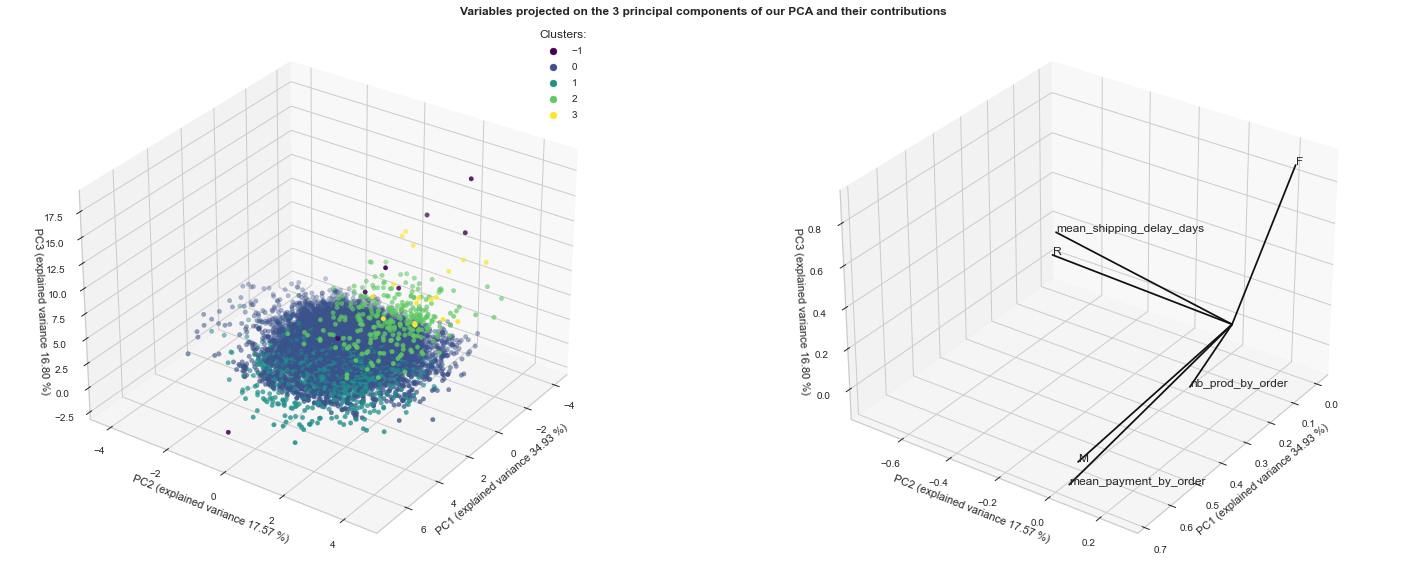

In [47]:
# PCA 3D viz
pca = decomposition.PCA(n_components=3)
pca.fit(X)
print(
    f'PCA in 3 dimension explain {pca.explained_variance_ratio_.sum()*100: .2f} % of the variance of our input data')
data_projected = pca.transform(X)
pcs = pca.components_

figure_3D_2 = plt.figure(figsize=(25, 10))
plt.title('Variables projected on the 3 principal components of our PCA and their contributions ',
          loc='center', fontweight='bold')
plt.axis('off')
ax = figure_3D_2.add_subplot(1,2,1, projection='3d')
a = ax.scatter(data_projected[:, 0], data_projected[:, 1], data_projected[:, 2],
               c=dbscan_model.labels_, cmap='viridis')
ax.set_xlabel(
    f'PC1 (explained variance {pca.explained_variance_ratio_[0]*100:.2f} %)')
ax.set_ylabel(
    f'PC2 (explained variance {pca.explained_variance_ratio_[1]*100:.2f} %)')
ax.set_zlabel(
    f'PC3 (explained variance {pca.explained_variance_ratio_[2]*100:.2f} %)')
ax.view_init(30, 35)
plt.legend(*a.legend_elements(), title='Clusters:')

ax2 = figure_3D_2.add_subplot(1, 2, 2, projection='3d')
for i, (x, y, z) in enumerate(zip(pcs[0, :], pcs[1, :], pcs[2, :])):
    ax2.plot([0, x], [0, y], [0, z], c='k')
    ax2.text(x, y, z, X.columns[i])
ax2.set_xlabel(
        f'PC1 (explained variance {pca.explained_variance_ratio_[0]*100:.2f} %)')
ax2.set_ylabel(
        f'PC2 (explained variance {pca.explained_variance_ratio_[1]*100:.2f} %)')
ax2.set_zlabel(
        f'PC3 (explained variance {pca.explained_variance_ratio_[2]*100:.2f} %)')
ax2.view_init(30, 35)

plt.savefig('DBSCAN_model_PCA_3D.jpg', dpi=300, bbox_inches='tight')
plt.show()
dbscan_model_color = [element.get_color()
                      for element in a.legend_elements('colors')[0]]

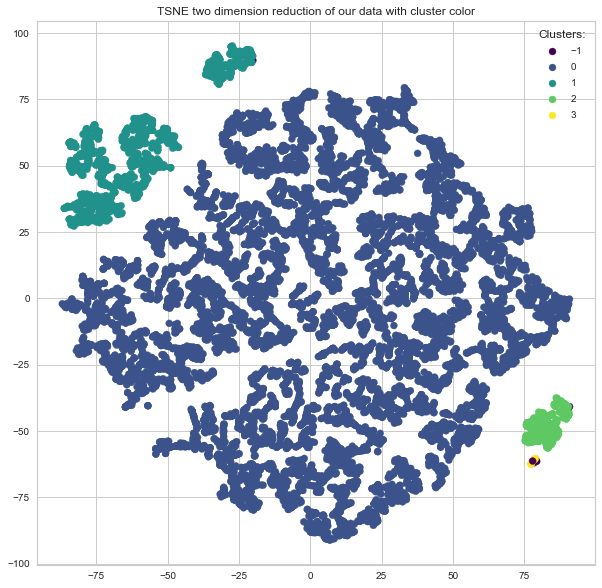

In [58]:
# tSNE viz
cluster_2D_TSNE_viz(X, dbscan_model, savefig=True,
                    comment='DBSCAN_4_clusters')

#### Metrics evaluations

In [125]:
tab_result = metrics_clusters(X, 4, dbscan_model, 'DBSCAN model', tab_result)
tab_result

Model Parameter_nb_cluster  Davies_boulin_score  Silhouette_score
0  Kmeans model                    5             1.121932          0.259692
1  DBSCAN model                    4             1.703873          0.390338

### **D) K_prototypes (using the same data as Kmeans model + 2 qualitative variables)**

--> We are using the same varibales as before but we 'add main_prod_cat' and 'main_payment_type' as categorical data

In [48]:
df_cat = df_data_RFM_period[['main_prod_cat', 'main_payment_type']].copy()
X_k_proto = pd.merge(X, df_cat, left_index=True, right_index=True, how='left')
X_k_proto

R         F         M  \
customer_unique_id                                               
0000f46a3911fa3c0805444483337064  0.887509 -0.149314 -0.262595   
0005e1862207bf6ccc02e4228effd9a0  0.997420 -0.149314  0.452860   
00115fc7123b5310cf6d3a3aa932699e  1.942653 -0.149314 -0.422963   
0011805441c0d1b68b48002f1d005526 -0.101689 -0.149314  1.337335   
0011857aff0e5871ce5eb429f21cdaf5 -1.530530 -0.149314  0.776857   
...                                    ...       ...       ...   
ffebb6424578e7bb153322da9d65634f  2.052564 -0.149314  2.384895   
ffedff0547d809c90c05c2691c51f9b7  0.447866 -0.149314 -1.511267   
ffef0ffa736c7b3d9af741611089729b -0.871065 -0.149314  0.354021   
ffff371b4d645b6ecea244b27531430a  1.568956 -0.149314  0.079768   
ffffd2657e2aad2907e67c3e9daecbeb -0.277546 -0.149314 -0.502129   

                                  nb_prod_by_order  mean_payment_by_order  \
customer_unique_id                                                          
0000f46a3911fa3c0805444483337064         -0.301939              -0.242366   
0005e1862207bf6ccc02e4228effd9a0         -0.301939               0.476846   
00115fc7123b5310cf6d3a3aa932699e         -0.301939              -0.403576   
0011805441c0d1b68b48002f1d005526         -0.301939               1.365966   
0011857aff0e5871ce5eb429f21cdaf5         -0.301939               0.802545   
...                                            ...                    ...   
ffebb6424578e7bb153322da9d65634f         -0.301939               2.419028   
ffedff0547d809c90c05c2691c51f9b7         -0.301939              -1.497595   
ffef0ffa736c7b3d9af741611089729b         -0.301939               0.377488   
ffff371b4d645b6ecea244b27531430a         -0.301939               0.101795   
ffffd2657e2aad2907e67c3e9daecbeb         -0.301939              -0.483158   

                                  mean_shipping_delay_days  \
customer_unique_id                                           
0000f46a3911fa3c0805444483337064                  1.516175   
0005e1862207bf6ccc02e4228effd9a0                 -1.391320   
00115fc7123b5310cf6d3a3aa932699e                 -0.000835   
0011805441c0d1b68b48002f1d005526                  0.963023   
0011857aff0e5871ce5eb429f21cdaf5                 -0.354728   
...                                                    ...   
ffebb6424578e7bb153322da9d65634f                  2.185424   
ffedff0547d809c90c05c2691c51f9b7                  0.152614   
ffef0ffa736c7b3d9af741611089729b                 -0.354728   
ffff371b4d645b6ecea244b27531430a                  0.546140   
ffffd2657e2aad2907e67c3e9daecbeb                 -0.562444   

                                             main_prod_cat main_payment_type  
customer_unique_id                                                            
0000f46a3911fa3c0805444483337064                stationery       credit_card  
0005e1862207bf6ccc02e4228effd9a0  fashion_bags_accessories       credit_card  
00115fc7123b5310cf6d3a3aa932699e            sports_leisure       credit_card  
0011805441c0d1b68b48002f1d005526     computers_accessories       credit_card  
0011857aff0e5871ce5eb429f21cdaf5       luggage_accessories       credit_card  
...                                                    ...               ...  
ffebb6424578e7bb153322da9d65634f                cool_stuff       credit_card  
ffedff0547d809c90c05c2691c51f9b7                housewares       credit_card  
ffef0ffa736c7b3d9af741611089729b            sports_leisure       credit_card  
ffff371b4d645b6ecea244b27531430a                      auto       credit_card  
ffffd2657e2aad2907e67c3e9daecbeb                 perfumery       credit_card  

[13266 rows x 8 columns]

In [49]:
# replace NaN value in categorie cat by 'unknown'
X_k_proto.fillna('unknown', inplace=True)

#### algoritm training and optimization with cost function (unsing like elbow method as before)

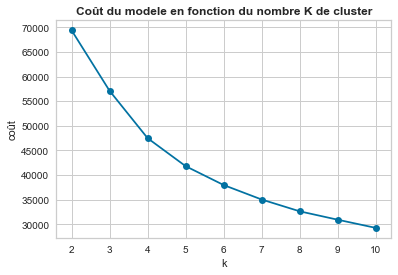

In [50]:
# Find the best number of cluster with cost calcul
list_cost = list()
for k in range(2, 11):
    K_proto_model = kprototypes.KPrototypes(n_clusters=k, n_jobs=-1)
    K_proto_model.fit(X_k_proto, categorical=[6, 7])
    list_cost.append(K_proto_model.cost_)

plt.title('Coût du modele en fonction du nombre K de cluster',
          fontweight='bold')
plt.plot(range(2, 11), list_cost, 'o-')
plt.xticks(range(2, 11))
plt.xlabel('k')
plt.ylabel('coût')
plt.savefig('Cout_model_fonction_clusters_K_prototypes.jpg', dpi=300, bbox_inches='tight')
plt.show()

--> let's try model with 5 cluster regarding previous results

#### Training model with 5 clusters

In [51]:
k_proto_model = kprototypes.KPrototypes(n_clusters=5)
k_proto_model.fit_predict(X_k_proto, categorical=[6, 7])

array([0, 0, 0, ..., 3, 0, 2], dtype=uint16)

#### Visualizations (with only numerical data)

PCA in 2 dimension explain  52.51 % of the variance of our input data


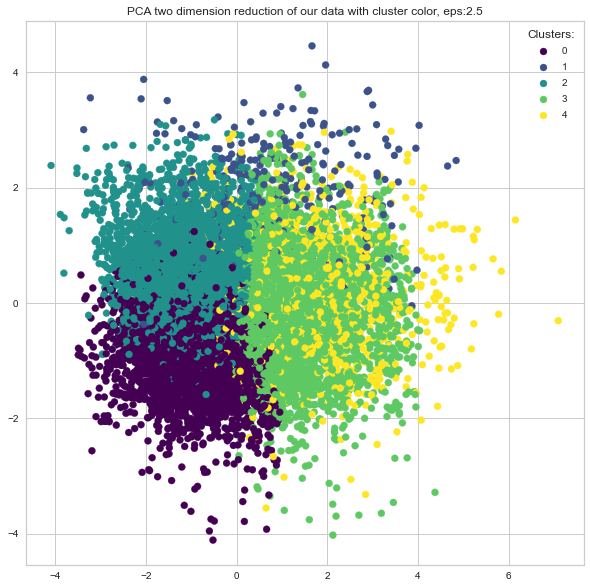

In [52]:
# PCA 2D viz
pca = decomposition.PCA(n_components=2)
pca.fit(X)
print(
    f'PCA in 2 dimension explain {pca.explained_variance_ratio_.sum()*100: .2f} % of the variance of our input data')
data_projected = pca.transform(X)
figure_PCA = plt.figure(figsize=(10, 10))
plt.title(
    f'PCA two dimension reduction of our data with cluster color, eps:{epsi}')
a = plt.scatter(data_projected[:, 0], data_projected[:, 1],
                c=k_proto_model.labels_, cmap='viridis')
plt.legend(*a.legend_elements(), title='Clusters:')
plt.savefig('k_prototypes_model_PCA_2D.jpg', dpi=300, bbox_inches='tight')
plt.show()

PCA in 3 dimension explain  69.31 % of the variance of our input data


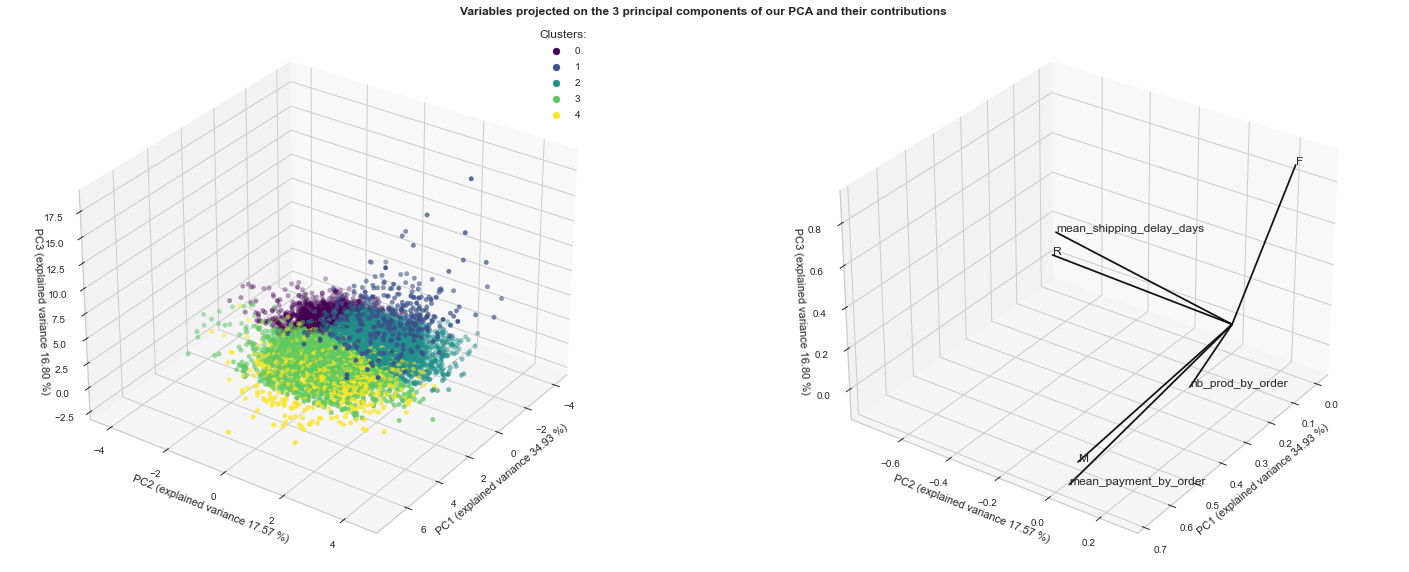

In [53]:
# PCA 3D viz
pca = decomposition.PCA(n_components=3)
pca.fit(X)
print(
    f'PCA in 3 dimension explain {pca.explained_variance_ratio_.sum()*100: .2f} % of the variance of our input data')
data_projected = pca.transform(X)
pcs = pca.components_

figure_3D_2 = plt.figure(figsize=(25, 10))
plt.title('Variables projected on the 3 principal components of our PCA and their contributions ',
          loc='center', fontweight='bold')
plt.axis('off')
ax = figure_3D_2.add_subplot(1,2,1, projection='3d')
a = ax.scatter(data_projected[:, 0], data_projected[:, 1], data_projected[:, 2],
               c=k_proto_model.labels_, cmap='viridis')
ax.set_xlabel(
    f'PC1 (explained variance {pca.explained_variance_ratio_[0]*100:.2f} %)')
ax.set_ylabel(
    f'PC2 (explained variance {pca.explained_variance_ratio_[1]*100:.2f} %)')
ax.set_zlabel(
    f'PC3 (explained variance {pca.explained_variance_ratio_[2]*100:.2f} %)')
ax.view_init(30, 35)
plt.legend(*a.legend_elements(), title='Clusters:')

ax2 = figure_3D_2.add_subplot(1, 2, 2, projection='3d')
for i, (x, y, z) in enumerate(zip(pcs[0, :], pcs[1, :], pcs[2, :])):
    ax2.plot([0, x], [0, y], [0, z], c='k')
    ax2.text(x, y, z, X.columns[i])
ax2.set_xlabel(
        f'PC1 (explained variance {pca.explained_variance_ratio_[0]*100:.2f} %)')
ax2.set_ylabel(
        f'PC2 (explained variance {pca.explained_variance_ratio_[1]*100:.2f} %)')
ax2.set_zlabel(
        f'PC3 (explained variance {pca.explained_variance_ratio_[2]*100:.2f} %)')
ax2.view_init(30, 35)

plt.savefig('K_prototypes_PCA_3D.jpg', dpi=300, bbox_inches='tight')
plt.show()
k_proto_model_color = [element.get_color()
                      for element in a.legend_elements('colors')[0]]

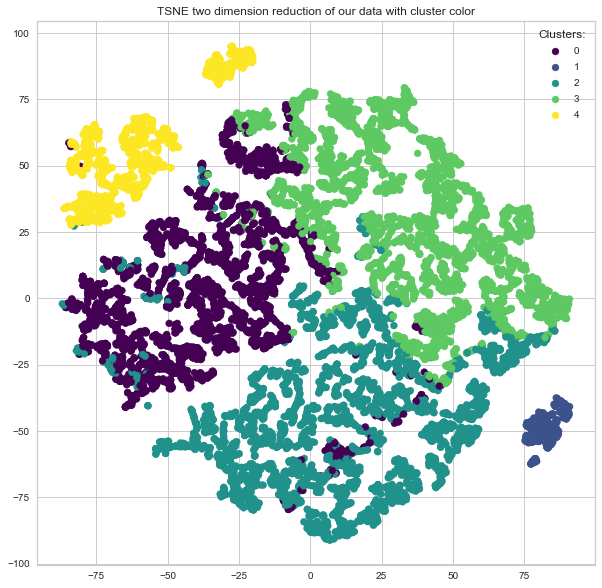

In [54]:
# tSNE viz
cluster_2D_TSNE_viz(X, k_proto_model, savefig=True,
                    comment='k_prototype_5_clusters')

#### Metrics evaluations

In [126]:
tab_result = metrics_clusters(X, 5, k_proto_model, 'K_prototypes model', tab_result)
tab_result

Model Parameter_nb_cluster  Davies_boulin_score  \
0        Kmeans model                    5             1.121932   
1        DBSCAN model                    4             1.703873   
2  K_prototypes model                    5             1.124184   

   Silhouette_score  
0          0.259692  
1          0.390338  
2          0.258775

### **E) Agglomerative clustering**

--> let's try dendogram to vizualise clusters

In [ ]:
# let's use a dendogram to represent our data
plt.figure(figsize=(15, 15))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.show()

--> Impossible to create a dendogram, after 3 hours still calculating...

In [ ]:
H_model_0 = AgglomerativeClustering(n_clusters=6)
H_model_0.fit_predict(X)

--> Same results if we try to fit a model with 6 clusters... Seems not adapted to our problematic.

### **F) Models comparison**

#### Visualization with tSNE dimension reduction on data X

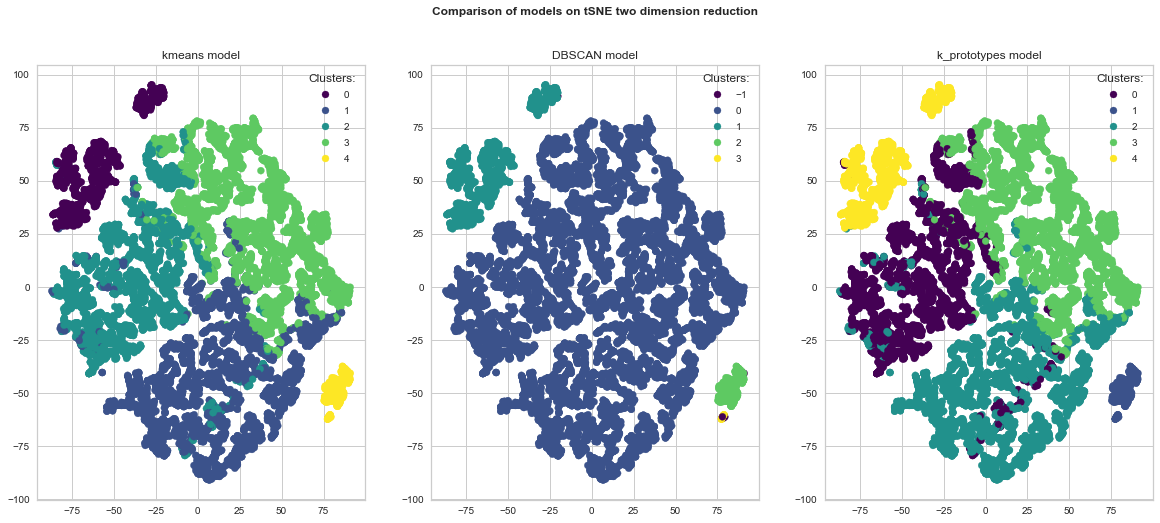

In [55]:
tsne_red = manifold.TSNE(n_components=2, perplexity=30, n_jobs=-1, random_state=0)
data_tsne_projected = tsne_red.fit_transform(X)
# Figures plot
figure_models = plt.figure(figsize=(20, 8))
plt.title('Comparison of models on tSNE two dimension reduction',
          fontweight='bold', pad=50)
plt.axis('off')
figure_models.add_subplot(1, 3, 1)
plt.title('kmeans model')
a = plt.scatter(data_tsne_projected[:, 0], data_tsne_projected[:, 1],
                c=kmeans_model.labels_, cmap='viridis')
plt.legend(*a.legend_elements(), title='Clusters:')
figure_models.add_subplot(1, 3, 2)
plt.title('DBSCAN model')
b = plt.scatter(data_tsne_projected[:, 0], data_tsne_projected[:, 1],
                c=dbscan_model.labels_, cmap='viridis')
plt.legend(*b.legend_elements(), title='Clusters:')
figure_models.add_subplot(1, 3, 3)
plt.title('k_prototypes model')
c = plt.scatter(data_tsne_projected[:, 0], data_tsne_projected[:, 1],
                c=k_proto_model.labels_, cmap='viridis')
plt.legend(*c.legend_elements(), title='Clusters:')
plt.savefig('models_comparison_tSNE.jpg', dpi=300, bbox_inches='tight')
plt.show()

--> Kmeans and k_prototypes are pretty much similar, categorical variables don't seem to bring good informations <br/>
--> DBSCAN seems less useful with less clustering <br/>
--> let's focus on k_means model

#### Metrics

In [128]:
tab_result

Model Parameter_nb_cluster  Davies_boulin_score  \
0        Kmeans model                    5             1.121932   
1        DBSCAN model                    4             1.703873   
2  K_prototypes model                    5             1.124184   

   Silhouette_score  
0          0.259692  
1          0.390338  
2          0.258775

## **III - Selected model: K_means with five clusters**

### **Clusters identification**

In [59]:
# adding our clusters label to our RFM initial data
df_data_RFM_period['K_means_clusters'] = kmeans_model.labels_

In [60]:
df_group_kmeans_clust = cluster_result(df_data_RFM_period, 'K_means_clusters')
df_group_kmeans_clust = df_group_kmeans_clust.reindex(
    range(0, len(df_group_kmeans_clust.index.unique())))
df_group_kmeans_clust

Number  Total_ammount      mean_R    mean_F      mean_M  \
K_means_clusters                                                            
0                   1206      254278.99   72.616086  1.000000  210.844934   
1                   4294      303115.10   34.729856  1.000000   70.590382   
2                   3443      252708.84  118.020041  1.000000   73.397862   
3                   4019     1037572.59   68.371237  1.000000  258.166855   
4                    304       76121.63   62.802632  2.095395  250.400099   

                  mean_payment_by_order  mean_seller_dist_km  \
K_means_clusters                                               
0                            210.844934           603.847741   
1                             70.590382           554.009631   
2                             73.397862           605.703243   
3                            258.166855           751.099849   
4                            121.440395           595.151470   

                  mean_shipping_delay_days  mean_review_score  mean_nb_prod  \
K_means_clusters                                                              
0                                12.418740           3.846739      2.331675   
1                                10.347694           4.262731      1.001397   
2                                11.990415           4.208442      1.002904   
3                                13.892013           4.184229      1.000000   
4                                11.644433           4.167215      2.480263   

                  mean_prod_by_order    main_cat_prod main_payment_type  \
K_means_clusters                                                          
0                           2.331675  furniture_decor       credit_card   
1                           1.001397       housewares       credit_card   
2                           1.002904  furniture_decor       credit_card   
3                           1.000000    health_beauty       credit_card   
4                           1.188596   bed_bath_table       credit_card   

                  ratio_expenditure  
K_means_clusters                     
0                        210.844934  
1                         70.590382  
2                         73.397862  
3                        258.166855  
4                        250.400099

figure not saved


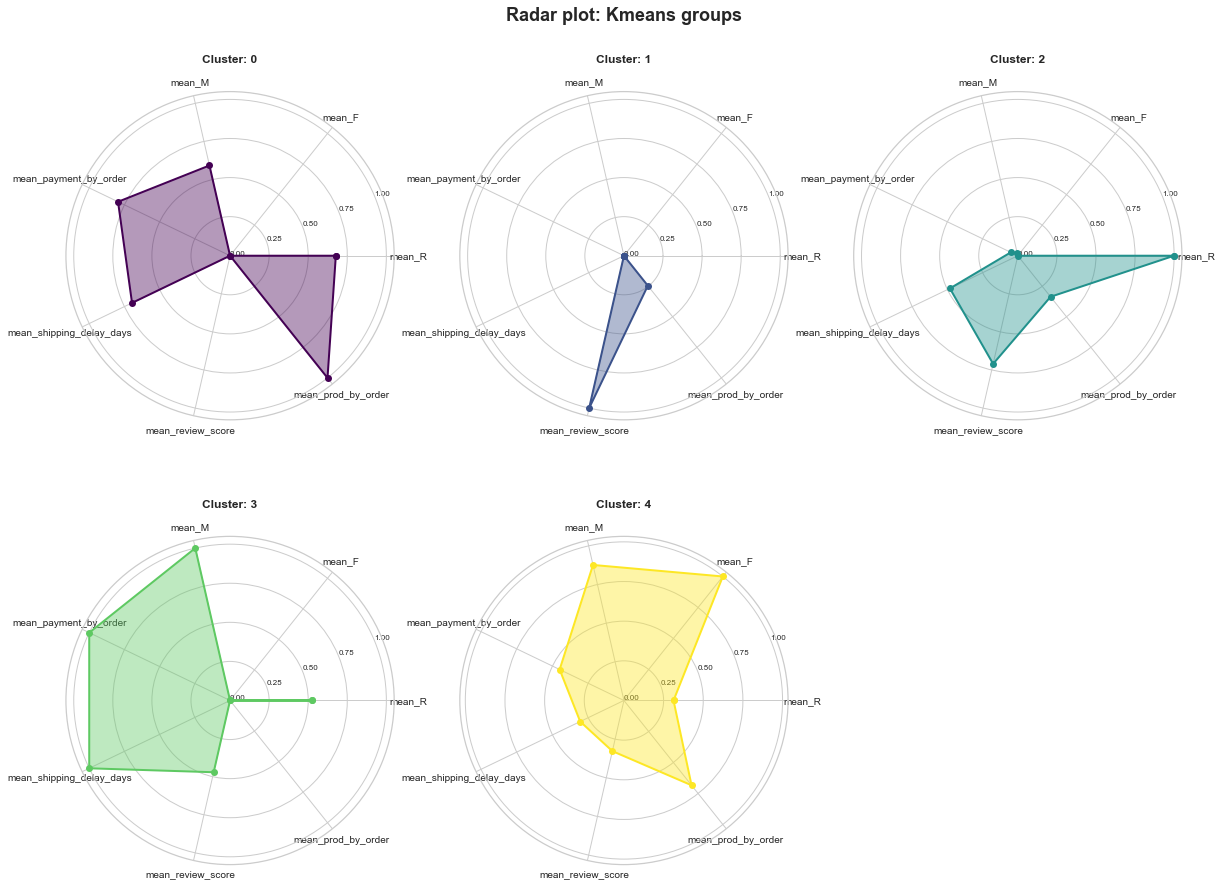

figure not saved


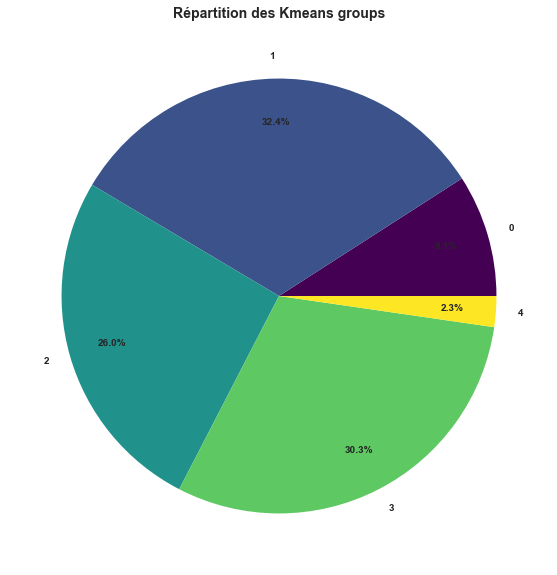

In [61]:
# using radar plot to indentify our clustering
radar_plot_groups(df_group_kmeans_clust, ['mean_R', 'mean_F', 'mean_M', 'mean_payment_by_order', 'mean_shipping_delay_days', 'mean_review_score', 'mean_prod_by_order'], markers=[
                  0, 0.25, 0.50, 0.75, 1], name='Kmeans groups', color_cluster=kmeans_model_colors, plot_size=(20, 15))

#### Function to define our clients

In [62]:
def cluster_name(x_cluster):
    ''' Function to convert our kmeans clusters into 5 client segment'''
    if x_cluster == 0:
        return('Acheteur compulsif')
    if x_cluster == 1:
        return('Nouveau')
    if x_cluster == 2:
        return('Occasionnel petit achats')
    if x_cluster == 3:
        return('Occasionel dépensier')
    if x_cluster == 4:
        return('Bon clients')

In [63]:
df_data_RFM_period['K_means_clusters_name'] = df_data_RFM_period['K_means_clusters'].apply(cluster_name)
df_data_RFM_period

R  F       M             main_prod_cat  \
customer_unique_id                                                           
0000f46a3911fa3c0805444483337064  111  1   86.22                stationery   
0005e1862207bf6ccc02e4228effd9a0  116  1  150.12  fashion_bags_accessories   
00115fc7123b5310cf6d3a3aa932699e  159  1   76.11            sports_leisure   
0011805441c0d1b68b48002f1d005526   66  1  297.14     computers_accessories   
0011857aff0e5871ce5eb429f21cdaf5    1  1  192.83       luggage_accessories   
...                               ... ..     ...                       ...   
ffebb6424578e7bb153322da9d65634f  164  1  665.70                cool_stuff   
ffedff0547d809c90c05c2691c51f9b7   91  1   32.42                housewares   
ffef0ffa736c7b3d9af741611089729b   31  1  139.07            sports_leisure   
ffff371b4d645b6ecea244b27531430a  142  1  112.46                      auto   
ffffd2657e2aad2907e67c3e9daecbeb   58  1   71.56                 perfumery   

                                  nb_prod  nb_prod_by_order  \
customer_unique_id                                            
0000f46a3911fa3c0805444483337064      1.0               1.0   
0005e1862207bf6ccc02e4228effd9a0      1.0               1.0   
00115fc7123b5310cf6d3a3aa932699e      1.0               1.0   
0011805441c0d1b68b48002f1d005526      1.0               1.0   
0011857aff0e5871ce5eb429f21cdaf5      1.0               1.0   
...                                   ...               ...   
ffebb6424578e7bb153322da9d65634f      1.0               1.0   
ffedff0547d809c90c05c2691c51f9b7      1.0               1.0   
ffef0ffa736c7b3d9af741611089729b      1.0               1.0   
ffff371b4d645b6ecea244b27531430a      1.0               1.0   
ffffd2657e2aad2907e67c3e9daecbeb      1.0               1.0   

                                                        top_seller  \
customer_unique_id                                                   
0000f46a3911fa3c0805444483337064  3d871de0142ce09b7081e2b9d1733cb1   
0005e1862207bf6ccc02e4228effd9a0  0cbcee27c791afa0cdcb08587a2013a8   
00115fc7123b5310cf6d3a3aa932699e  54a1852d1b8f10312c55e906355666ee   
0011805441c0d1b68b48002f1d005526  96493fab2fbb13a14d0c0e8772eef5c3   
0011857aff0e5871ce5eb429f21cdaf5  9d5a9018aee56acb367ba9c3f05d1d6a   
...                                                            ...   
ffebb6424578e7bb153322da9d65634f  dc317f341ab0e22f39acbd9dbf9b4a1f   
ffedff0547d809c90c05c2691c51f9b7  dd2bdf855a9172734fbc3744021ae9b9   
ffef0ffa736c7b3d9af741611089729b  c3cfdc648177fdbbbb35635a37472c53   
ffff371b4d645b6ecea244b27531430a  54aa8463e87776b5612f4bdc4bd5d4de   
ffffd2657e2aad2907e67c3e9daecbeb  cc419e0650a3c5ba77189a1882b7556a   

                                  mean_seller_dist_km  \
customer_unique_id                                      
0000f46a3911fa3c0805444483337064           517.883143   
0005e1862207bf6ccc02e4228effd9a0           245.860181   
00115fc7123b5310cf6d3a3aa932699e           774.662274   
0011805441c0d1b68b48002f1d005526          2211.443664   
0011857aff0e5871ce5eb429f21cdaf5           819.508679   
...                                               ...   
ffebb6424578e7bb153322da9d65634f           857.245703   
ffedff0547d809c90c05c2691c51f9b7           425.655874   
ffef0ffa736c7b3d9af741611089729b          1185.417662   
ffff371b4d645b6ecea244b27531430a          1527.160181   
ffffd2657e2aad2907e67c3e9daecbeb           356.318489   

                                  mean_shipping_delay_days  \
customer_unique_id                                           
0000f46a3911fa3c0805444483337064                      25.0   
0005e1862207bf6ccc02e4228effd9a0                       4.0   
00115fc7123b5310cf6d3a3aa932699e                      10.0   
0011805441c0d1b68b48002f1d005526                      18.0   
0011857aff0e5871ce5eb429f21cdaf5                       8.0   
...                                                    ...   
ffebb6424578e7bb153322da9d65634f                    

In [64]:
df_group_kmeans_clust_name = df_group_kmeans_clust.copy()
df_group_kmeans_clust_name.index = df_group_kmeans_clust_name.index.map(cluster_name)
df_group_kmeans_clust_name

Number  Total_ammount      mean_R    mean_F  \
K_means_clusters                                                        
Acheteur compulsif          1206      254278.99   72.616086  1.000000   
Nouveau                     4294      303115.10   34.729856  1.000000   
Occasionnel petit achats    3443      252708.84  118.020041  1.000000   
Occasionel dépensier        4019     1037572.59   68.371237  1.000000   
Bon clients                  304       76121.63   62.802632  2.095395   

                              mean_M  mean_payment_by_order  \
K_means_clusters                                              
Acheteur compulsif        210.844934             210.844934   
Nouveau                    70.590382              70.590382   
Occasionnel petit achats   73.397862              73.397862   
Occasionel dépensier      258.166855             258.166855   
Bon clients               250.400099             121.440395   

                          mean_seller_dist_km  mean_shipping_delay_days  \
K_means_clusters                                                          
Acheteur compulsif                 603.847741                 12.418740   
Nouveau                            554.009631                 10.347694   
Occasionnel petit achats           605.703243                 11.990415   
Occasionel dépensier               751.099849                 13.892013   
Bon clients                        595.151470                 11.644433   

                          mean_review_score  mean_nb_prod  mean_prod_by_order  \
K_means_clusters                                                                
Acheteur compulsif                 3.846739      2.331675            2.331675   
Nouveau                            4.262731      1.001397            1.001397   
Occasionnel petit achats           4.208442      1.002904            1.002904   
Occasionel dépensier               4.184229      1.000000            1.000000   
Bon clients                        4.167215      2.480263            1.188596   

                            main_cat_prod main_payment_type  ratio_expenditure  
K_means_clusters                                                                
Acheteur compulsif        furniture_decor       credit_card         210.844934  
Nouveau                        housewares       credit_card          70.590382  
Occasionnel petit achats  furniture_decor       credit_card          73.397862  
Occasionel dépensier        health_beauty       credit_card         258.166855  
Bon clients                bed_bath_table       credit_card         250.400099

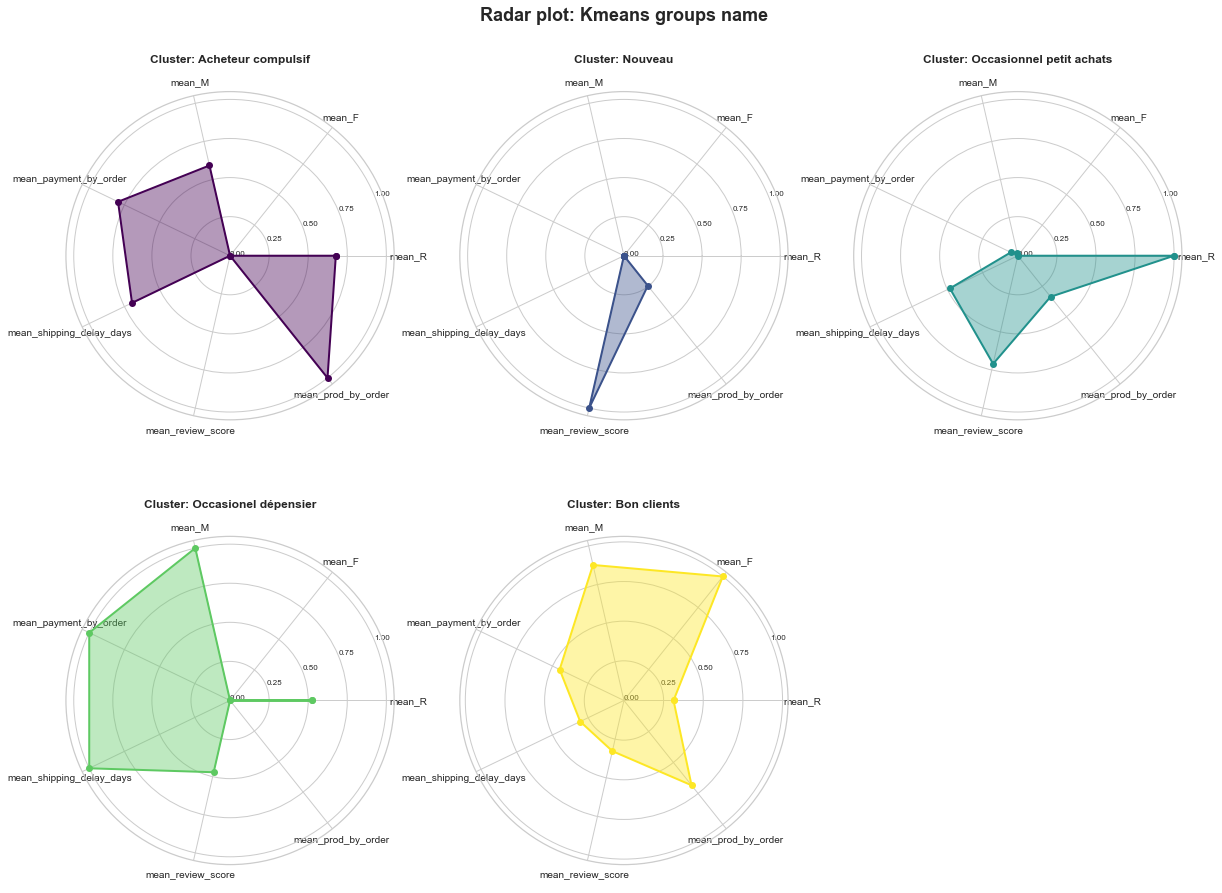

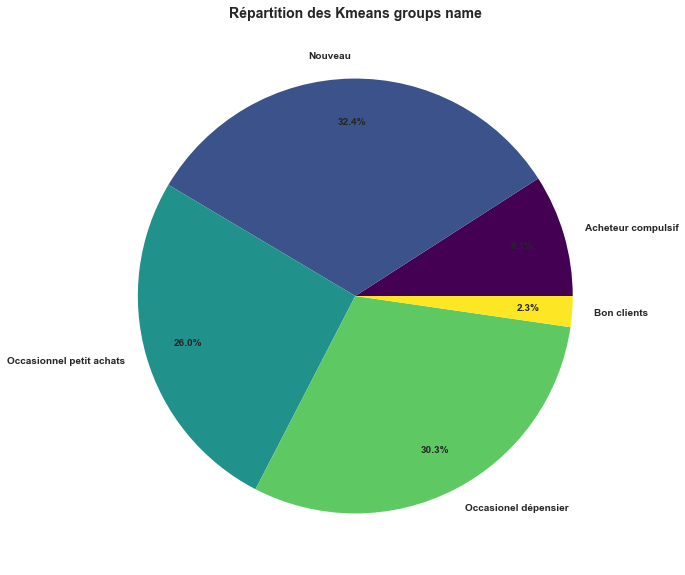

In [65]:
radar_plot_groups(df_group_kmeans_clust_name, ['mean_R', 'mean_F', 'mean_M', 'mean_payment_by_order', 'mean_shipping_delay_days', 'mean_review_score', 'mean_prod_by_order'], markers=[
                  0, 0.25, 0.50, 0.75, 1], name='Kmeans groups name', color_cluster=kmeans_model_colors, plot_size=(20, 15), savefig=True)

figure not saved


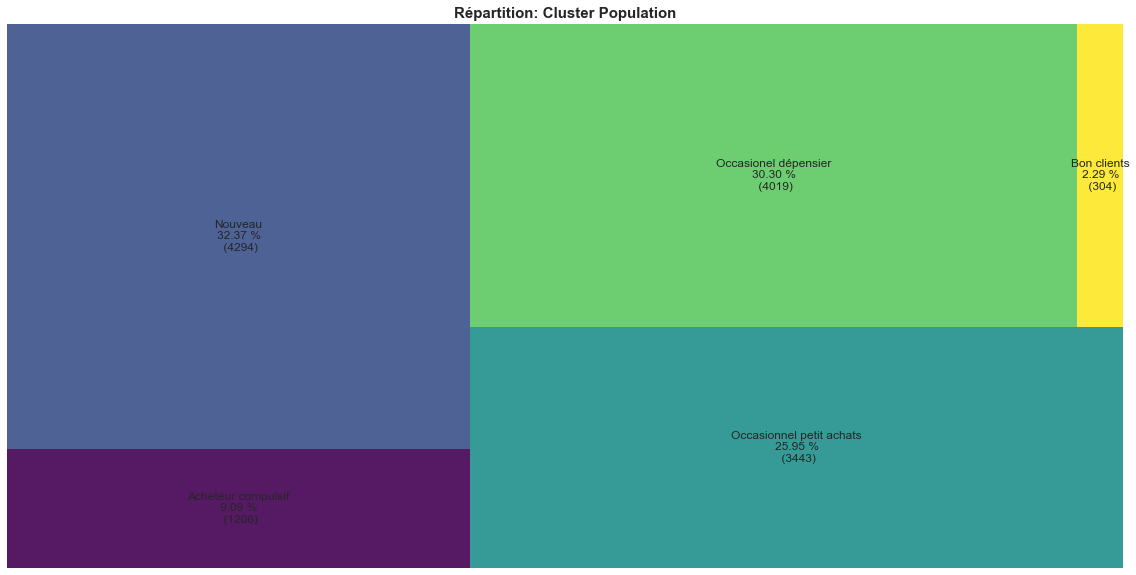

In [66]:
treemap(df_group_kmeans_clust_name, 'Number', 'Cluster Population',
        color_cluster=kmeans_model_colors, plot_size=(20, 10))

#### Specific customer informations

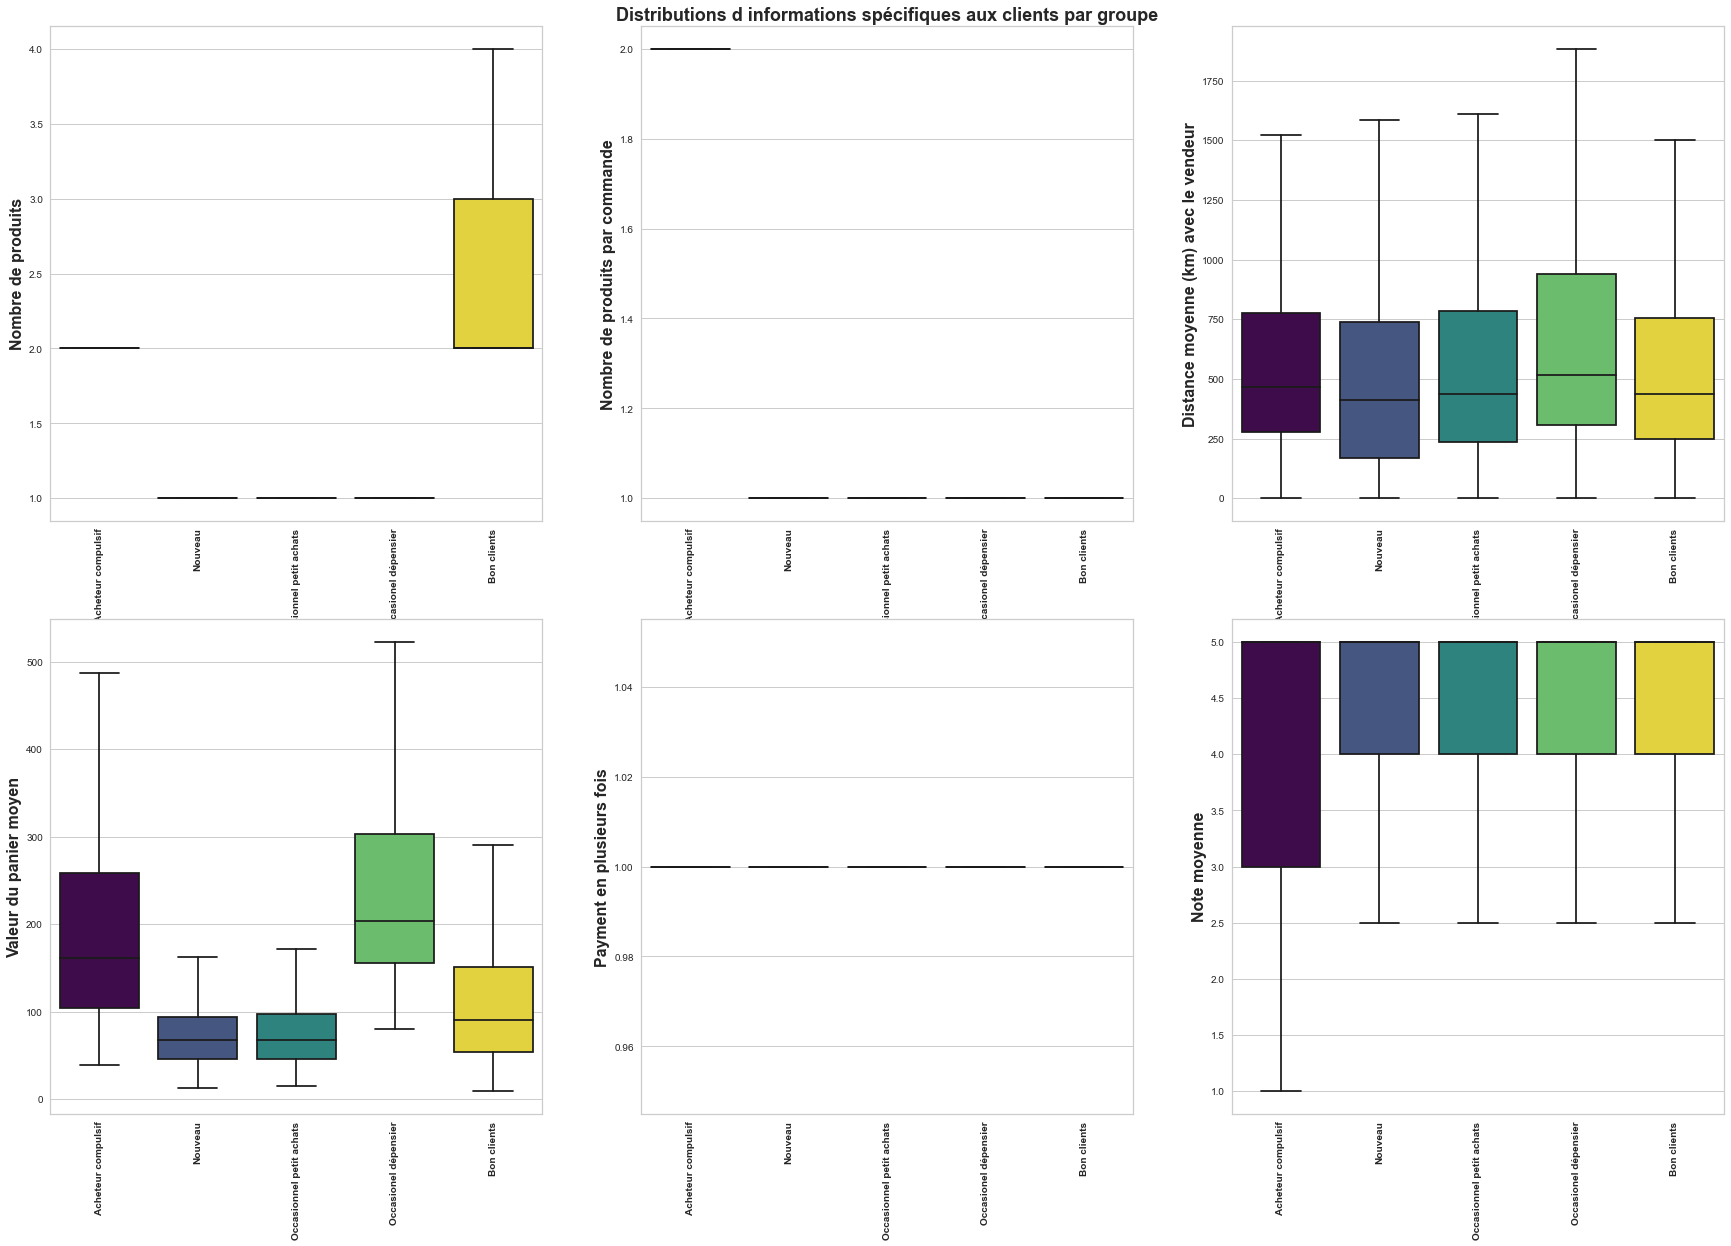

In [72]:
boxplot_specific_customer_infos_by_group(
    df_data_RFM_period, df_group_kmeans_clust_name, 'K_means_clusters_name', kmeans_model_colors, savefig=True)

#### Specific products informations (by cluster)

Pour le groupe Acheteur compulsif:
- L article le plus vendu --> 99a4788cb24856965c36a24e339b6058
- Le vendeur le plus sollicité --> cca3071e3e9bb7d12640c9fbe2301306
- La catégorie la plus achetée --> furniture_decor
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Pour le groupe Nouveau:
- L article le plus vendu --> 99a4788cb24856965c36a24e339b6058
- Le vendeur le plus sollicité --> cc419e0650a3c5ba77189a1882b7556a
- La catégorie la plus achetée --> housewares
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Pour le groupe Occasionnel petit achats:
- L article le plus vendu --> 7e0dc102074f8285580c9777f79c90cf
- Le vendeur le plus sollicité --> cca3071e3e9bb7d12640c9fbe2301306
- La catégorie la plus achetée --> furniture_decor
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Pour le groupe Occasionel dépensier:
- L article le plus vendu --> 601a360bd2a916ecef0e88de72a6531a
- Le vendeur le 

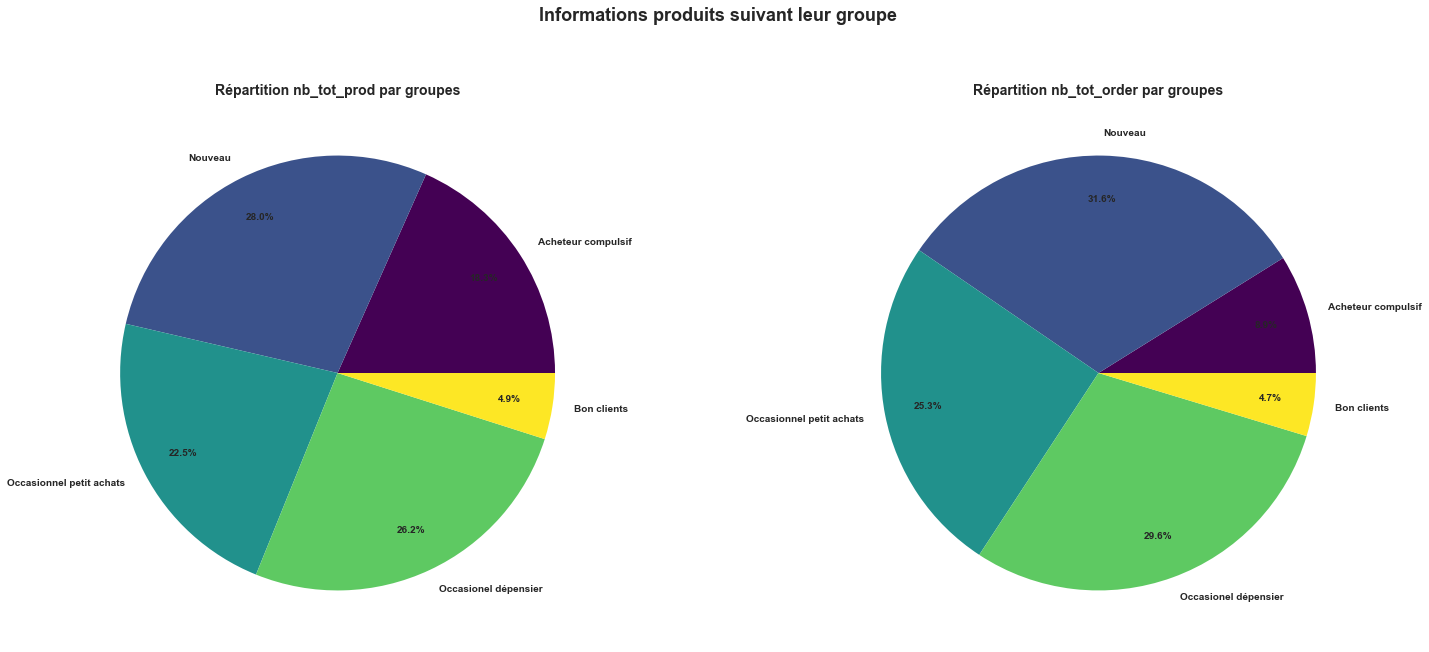

nb_tot_prod  nb_tot_order  \
K_means_clusters                                      
Acheteur compulsif               2812          1206   
Nouveau                          4300          4294   
Occasionnel petit achats         3453          3443   
Occasionel dépensier             4019          4019   
Bon clients                       754           637   

                                                 best_prod  \
K_means_clusters                                             
Acheteur compulsif        99a4788cb24856965c36a24e339b6058   
Nouveau                   99a4788cb24856965c36a24e339b6058   
Occasionnel petit achats  7e0dc102074f8285580c9777f79c90cf   
Occasionel dépensier      601a360bd2a916ecef0e88de72a6531a   
Bon clients               7c68e7297c7df2535c9f0dcd61007f64   

                                               best_seller         main_cat  
K_means_clusters                                                             
Acheteur compulsif        cca3071e3e9bb7d12640c9fbe2301306  furniture_decor  
Nouveau                   cc419e0650a3c5ba77189a1882b7556a       housewares  
Occasionnel petit achats  cca3071e3e9bb7d12640c9fbe2301306  furniture_decor  
Occasionel dépensier      7a67c85e85bb2ce8582c35f2203ad736    health_beauty  
Bon clients               cca3071e3e9bb7d12640c9fbe2301306   bed_bath_table

In [68]:
products_infos_cluster(df_data_global_olist_period, df_data_RFM_period,
                       df_group_kmeans_clust_name, 'K_means_clusters_name', colors=kmeans_model_colors)

### Comparison with RFM model

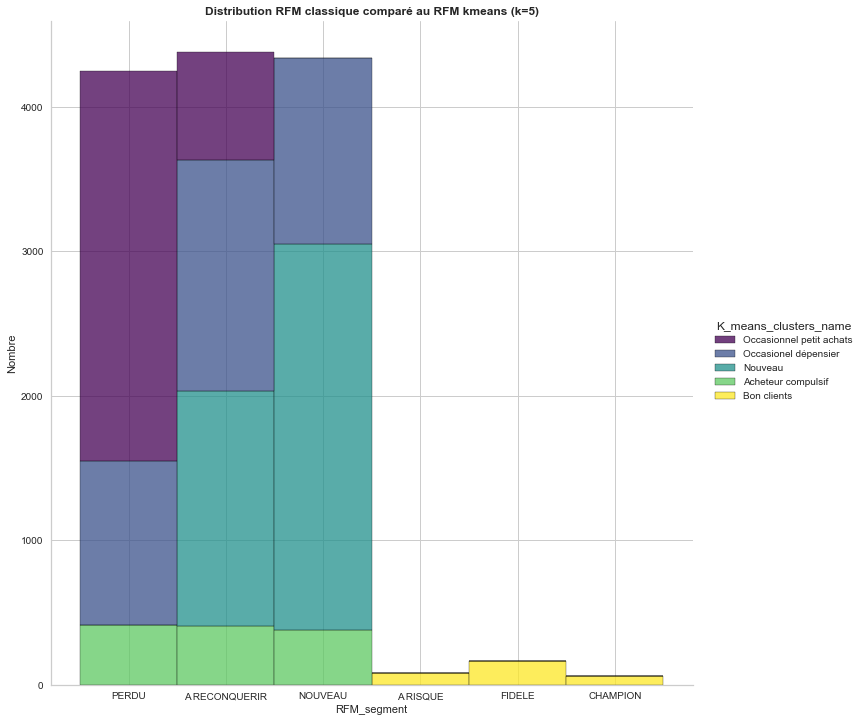

In [70]:
ax=sns.displot(x='RFM_segment', hue='K_means_clusters_name',
            data=df_data_RFM_period, palette=kmeans_model_colors, multiple='stack', height=10)
plt.title('Distribution RFM classique comparé au RFM kmeans (k=5)',
          fontweight='bold')
plt.ylabel('Nombre')
plt.savefig('coparaison modèle_RFM.jpg', dpi=300, bbox_inches='tight')
plt.show()

### **Update model evaluation**

In [73]:
# initial clustering, we use 'k-means ++'' initialization
# Clustering stability first
def K_means_stability(data_clustering, n_clusters, n_training):
    ''' Function to evaluate the stability of a K_means cluster at T, it uses 'k_means++' init method
    data_clustering --> numerical data to input to the algorithm should be standardized!
    n_clusters --> number of cluster of the K_means algorithm
    n_training --> number of different training to use
    It returns the ARI mean score between a reference algorithm 0 and all the other algorithm clustering and the labels from the first trained model'''

    cluster_labels = list()
    ARI_scores = list()

    kmeans_model_0 = KMeans(n_clusters=n_clusters)
    kmeans_model_0.fit(data_clustering)
    cluster_labels.append(kmeans_model_0.labels_)

    # loop to train several time the clustering
    for clusteri in range(1, n_training + 1):
        kmeans_model_i = KMeans(n_clusters=n_clusters)
        kmeans_model_i.fit(data_clustering)
        cluster_labels.append(kmeans_model_i.labels_)

    # loop for calculate each ARI scores
    for modeli in range(1, n_training + 1):
        ARI_scores.append(metrics.adjusted_rand_score(
            cluster_labels[0], cluster_labels[modeli]))
    mean_ARI = np.mean(ARI_scores)
    return mean_ARI

--> let's try on our model (at instant T)

In [74]:
K_means_stability(df_data_models_std, 5, 100)

0.9916795306857782

In [154]:
# Base data to train the first cluster and get the index client
list_cluster_variables = ['R', 'F', 'M', 'nb_prod_by_order',
                          'mean_payment_by_order', 'mean_shipping_delay_days']
df_customer_period_0, df_olist_period_0 = customer_infos_time(
    df_data_global_olist, '2017-01-01', '2017-06-30', name='Data_customer_period0')
df_customer_period_0

R  F       M             main_prod_cat  \
customer_unique_id                                                           
0000f46a3911fa3c0805444483337064  111  1   86.22                stationery   
0005e1862207bf6ccc02e4228effd9a0  116  1  150.12  fashion_bags_accessories   
00115fc7123b5310cf6d3a3aa932699e  159  1   76.11            sports_leisure   
0011805441c0d1b68b48002f1d005526   66  1  297.14     computers_accessories   
0011857aff0e5871ce5eb429f21cdaf5    1  1  192.83       luggage_accessories   
...                               ... ..     ...                       ...   
ffebb6424578e7bb153322da9d65634f  164  1  665.70                cool_stuff   
ffedff0547d809c90c05c2691c51f9b7   91  1   32.42                housewares   
ffef0ffa736c7b3d9af741611089729b   31  1  139.07            sports_leisure   
ffff371b4d645b6ecea244b27531430a  142  1  112.46                      auto   
ffffd2657e2aad2907e67c3e9daecbeb   58  1   71.56                 perfumery   

                                  nb_prod  nb_prod_by_order  \
customer_unique_id                                            
0000f46a3911fa3c0805444483337064      1.0               1.0   
0005e1862207bf6ccc02e4228effd9a0      1.0               1.0   
00115fc7123b5310cf6d3a3aa932699e      1.0               1.0   
0011805441c0d1b68b48002f1d005526      1.0               1.0   
0011857aff0e5871ce5eb429f21cdaf5      1.0               1.0   
...                                   ...               ...   
ffebb6424578e7bb153322da9d65634f      1.0               1.0   
ffedff0547d809c90c05c2691c51f9b7      1.0               1.0   
ffef0ffa736c7b3d9af741611089729b      1.0               1.0   
ffff371b4d645b6ecea244b27531430a      1.0               1.0   
ffffd2657e2aad2907e67c3e9daecbeb      1.0               1.0   

                                                        top_seller  \
customer_unique_id                                                   
0000f46a3911fa3c0805444483337064  3d871de0142ce09b7081e2b9d1733cb1   
0005e1862207bf6ccc02e4228effd9a0  0cbcee27c791afa0cdcb08587a2013a8   
00115fc7123b5310cf6d3a3aa932699e  54a1852d1b8f10312c55e906355666ee   
0011805441c0d1b68b48002f1d005526  96493fab2fbb13a14d0c0e8772eef5c3   
0011857aff0e5871ce5eb429f21cdaf5  9d5a9018aee56acb367ba9c3f05d1d6a   
...                                                            ...   
ffebb6424578e7bb153322da9d65634f  dc317f341ab0e22f39acbd9dbf9b4a1f   
ffedff0547d809c90c05c2691c51f9b7  dd2bdf855a9172734fbc3744021ae9b9   
ffef0ffa736c7b3d9af741611089729b  c3cfdc648177fdbbbb35635a37472c53   
ffff371b4d645b6ecea244b27531430a  54aa8463e87776b5612f4bdc4bd5d4de   
ffffd2657e2aad2907e67c3e9daecbeb  cc419e0650a3c5ba77189a1882b7556a   

                                  mean_seller_dist_km  \
customer_unique_id                                      
0000f46a3911fa3c0805444483337064           517.883143   
0005e1862207bf6ccc02e4228effd9a0           245.860181   
00115fc7123b5310cf6d3a3aa932699e           774.662274   
0011805441c0d1b68b48002f1d005526          2211.443664   
0011857aff0e5871ce5eb429f21cdaf5           819.508679   
...                                               ...   
ffebb6424578e7bb153322da9d65634f           857.245703   
ffedff0547d809c90c05c2691c51f9b7           425.655874   
ffef0ffa736c7b3d9af741611089729b          1185.417662   
ffff371b4d645b6ecea244b27531430a          1527.160181   
ffffd2657e2aad2907e67c3e9daecbeb           356.318489   

                                  mean_shipping_delay_days  \
customer_unique_id                                           
0000f46a3911fa3c0805444483337064                      25.0   
0005e1862207bf6ccc02e4228effd9a0                       4.0   
00115fc7123b5310cf6d3a3aa932699e                      10.0   
0011805441c0d1b68b48002f1d005526                      18.0   
0011857aff0e5871ce5eb429f21cdaf5                       8.0   
...                                                    ...   
ffebb6424578e7bb153322da9d65634f                    

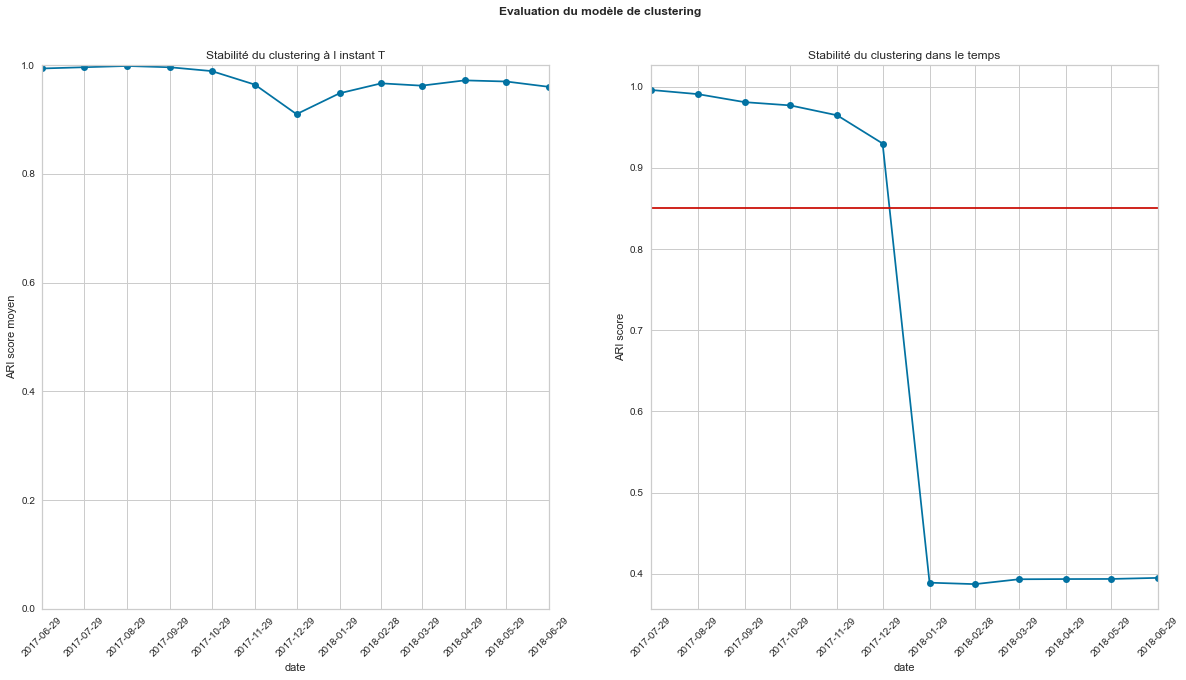

In [157]:
# Clustering stability in time

list_cluster_variables = ['R', 'F', 'M', 'nb_prod_by_order',
                          'mean_payment_by_order', 'mean_shipping_delay_days']
# preprocessing base data
X0 = preprocessing_custom_log1(
    df_customer_period_0[list_cluster_variables], df_customer_period_0[list_cluster_variables].columns[1:])
X0
k_means_model_0 = KMeans(n_clusters=5)
k_means_model_0.fit(X0)
# Define variables and the list to use in the loop
starting_date_base = (df_olist_period_0['order_purchase_timestamp'].min())
end_date_base = (df_olist_period_0['order_purchase_timestamp'].max())
cluster_period_label = list()
ARI_mean_list = list()
ARI_period_label_list = list()
time_period_range = [end_date_base]

ARI_mean = K_means_stability(X0, 5, 100)
ARI_mean_list.append(ARI_mean)
# filtereing with the same clients of our basis data
df_olist_data_filtered = df_data_global_olist.loc[df_data_global_olist['customer_unique_id'].isin(df_customer_period_0.index)]

# defining new datas for the new period and calculate new data
for i in range(1, 13):
    end_date_new_period = (end_date_base + pd.offsets.DateOffset(months=i))
    df_customer_period_i, _ = customer_infos_time(
        df_olist_data_filtered, starting_date_base, end_date_new_period, name=f'customer_period{i}')
    Xi = preprocessing_custom_log1(
        df_customer_period_i[list_cluster_variables], df_customer_period_i[list_cluster_variables].columns[1:])
    time_period_range.append(end_date_new_period)
    # predict cluster with old model on our new data
    k_means_model_0_labels_i = k_means_model_0.predict(Xi)
    # training new model on our data and testing its stability
    kmeans_model_i = KMeans(n_clusters=5)
    kmeans_model_i.fit(Xi)
    ARI_mean_list.append(K_means_stability(Xi, 5, 100))
    # ARI score between old and new model
    ARI_period_label_list.append(metrics.adjusted_rand_score(
        k_means_model_0_labels_i, kmeans_model_i.labels_))

# plot graphique for stability of each model and stability in time
figure_ARI = plt.figure(figsize=(20, 10))
plt.title('Evaluation du modèle de clustering', fontweight='bold', pad=50)
plt.axis('off')
figure_ARI.add_subplot(1, 2, 1)
plt.title('Stabilité du clustering à l instant T')
plt.plot_date(time_period_range, ARI_mean_list, 'o-')
plt.xticks(time_period_range,rotation = 45)
plt.xlabel('date')
plt.xlim(time_period_range[0], time_period_range[-1])
plt.ylim(0, 1)
plt.ylabel('ARI score moyen')
figure_ARI.add_subplot(1, 2, 2)
plt.title('Stabilité du clustering dans le temps')
plt.plot_date(time_period_range[1:], ARI_period_label_list, 'o-')
plt.plot_date(time_period_range[1:], [0.85 for i in time_period_range[1:]], '-', c='r')
plt.xticks(time_period_range[0:], rotation = 45)
plt.xlabel('date')
plt.xlim(time_period_range[1], time_period_range[-1])
plt.ylabel('ARI score')
plt.savefig('Contrat de maintenance_kmeans.jpg', dpi=300, bbox_inches='tight')
plt.show()